<a href="https://colab.research.google.com/github/haelipark/My_repository/blob/master/Intro_to_Linear_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning Fundamentals - Intro to Linear Methods


***
We will be focusing on regression based problems today, but most of what we discuss applies readily to categorical prediction questions.

<img src="https://miro.medium.com/max/3200/1*ASYpFfDh7XnreU-ygqXonw.png" width="600">

image credit [blog](https://towardsdatascience.com/supervised-vs-unsupervised-learning-14f68e32ea8d)


We are going to be going through a lot of material today! So feel free to revisit this notebook. Also, please grab code for your own projects!

**Topics covered in this lecture:**

*   Linear Regression with gradient descent 
*   The importance of a good train/test split 
*   Simple Model Evaluation
*   Bias/Variance Trade-off
*   Regularization - powerful 
   




## Import Needed Python Packages


I would like to formally acknowledge: 

**Burke, A., 2020: "Traditional Machine Learning Pipeline Applied to NWP Model Data"**

and **Ankur Mahesh** as large part inspiration/direct representation of this lecture material. 


The data for this tutorial can be cited as: 

    McGovern, A., Burke, A., Harrison, D., and G. M. Lackmann, 2020: A Machine Learning Tutorial for Operational Forecasting: Part I. Wea. Forecasting, In Press 



#Let's First Import the Necessary Python Packages

In [ ]:
%matplotlib inline
!pip install netcdf4 #package for handling netcdf files
import xarray as xr #best package ever for handling gridded/temporal data
import pandas as pd #data structures 
import numpy as np #best lin.alg. functions. math
import sklearn #machine learning toolbox
from tqdm import tqdm #time your loops

! pip install -U --no-cache-dir gdown --pre #downloading data from google drive 
# import gdown #downloading from google drive 

from matplotlib import pyplot as plt #plotting 
import matplotlib.pyplot as plt #plotting
import matplotlib #plotting 
import matplotlib.dates as dates #plotting
import datetime #time handling 

#sklearn tool box. Pre-Built Machine Learning tool boxes. 
# https://scikit-learn.org/stable/
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import scipy #algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations, differential equations, statistics

import warnings # this one is self explanatory 
warnings.filterwarnings('ignore')

!pip install mlxtend
import mlxtend #machine learning extensions/functions



Prevent Auto Scrolling

the next cell prevents output in the notebook from being nested in a scroll box

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;

<IPython.core.display.Javascript object>

## Useful functions we will use

In [ ]:
# Function to split data based on given dates
def split_data_year(input_data,labels,start_date_str,end_date_str):
  data = input_data.copy()
  date_list = pd.to_datetime(data['date'])
  date_mask = (date_list > start_date_str) & (date_list <= end_date_str)
  out_data = data.loc[date_mask,:].drop(['date'],axis=1)
  out_labels = labels.loc[date_mask,:]
  return out_data,out_labels


## Datasets Description: 


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/NWS_Weather_Forecast_Offices.svg/720px-NWS_Weather_Forecast_Offices.svg.png" width="600">


We are going to mimic the [WxChallenge](https://www.wxchallenge.com/) (with slight changes for time constraints)
  - Use regression to predict the high/low temperature of a given city
  - Use classification to predict whether precipitation will occur at a given city.
  - Relatively straight forward problem that is familiar to many meteorologists 
  - Learn the ML process on one city and apply you knowledge to an entirely different prediction problem or to another city, it is up to you! (See section 10)


 **Dataset Information**
- Numerical Weather Prediction (NWP) point forecasts from the Iowa Environmental Mesonet between 1 January 2011 to 1 August 2019
- 24-hour forecast runs from the GFS, NAM, RAP, and NAM 4km at 0000, 0600, 1200, and 1800 UTC
- 70 hourly forecast variables for each model 
- NWP variables processed into 24-hour maximum, minimum, and average values for the 0600 to 0600 UTC period (same as WxChallenge)
- If one NWP forecast is missing, replaced with average value from all other NWP forecasts for the given variable
- Observations are NWS ASOS point data for a given city  
- Days with missing observations were removed

Nino3.4 index time series from the [NCAR Climate Gateway](https://www.earthsystemgrid.org/) and Monthly SST Anomalies from the [Cobe V2. dataset](https://www.esrl.noaa.gov/psd/data/gridded/data.cobe2.html)


<img src="https://drive.google.com/uc?id=1xWRCICvpskmpOSwWWz78GRmCsO3Twdym" width="500">


**Nino3.4** is a time series of sea surface temperature [SST] anomalies averaged in the tropical pacific (lat [5N-5S], lon [170W-120W]). The index typically consists of a 5- month running mean SST field

The **Cobe V2.** data set is a 1.0 degree latitude x 1.0 degree longitude global grid (180x360) resolution sea surface tempearture field which spans latitude: 89.5N - 89.5S, and longitude: 0.5E - 359.5E. is analysis, a daily SST field is constructed as a sum of a trend, interannual variations, and daily changes, using in situ SST and sea ice concentration observations. 

# QUICK COLAB INTRO


In [ ]:
!ls -lathr

total 413M
-rw-r--r-- 1 root root  413M Dec  6  2019 sst.mon.mean.trefadj.anom.1880to2018.nc
-rw-r--r-- 1 root root   16K Dec  6  2019 nino34.long.anom.data.txt
drwxr-xr-x 4 root root  4.0K Jan  7 14:33 .config
drwxr-xr-x 1 root root  4.0K Jan  7 14:33 sample_data
-rwxr-xr-x 1  502 staff  312 Jan 10 20:53 ._.
drwxr-xr-x 1 root root  4.0K Jan 12 14:34 ..
drwxr-xr-x 2 root root  4.0K Jan 12 14:36 AI_tutorial_data
drwxr-xr-x 1  502 staff 4.0K Jan 12 14:36 .


In [ ]:
!ls
!ls ./sample_data/

sample_data
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


# This next cell downloads the data for the tutorial! 
It might take a little bit of time! 

In [ ]:
import gdown
! cd /content
!wget -O "AI_tutorial_data.tar.gz"  "https://zenodo.org/record/5834841/files/AI_tutorial_data.tar.gz?download=1"
!tar -xzvf AI_tutorial_data.tar.gz
!mkdir ./AI_tutorial_data
!mv *.csv ./AI_tutorial_data
!mv .*.csv ./AI_tutorial_data
! rm *.tar.gz 
!ls -lathr
#get data for this section:
!pip install netCDF4

! tar -xzvf AI_tutorial_data.tar.gz
! rm *.tar.gz 
! rm sst.mon.mean.*.nc 
! rm nino34.long.anom.*.txt
!ls

# MLurl = 'https://drive.google.com/file/d/18WPuSt0H6XDaHzDbd8PiQdB4tGric1vl/view?usp=sharing'
# MLoutput = 'nino34.long.anom.data.txt'
# gdown.download(MLurl, MLoutput, quiet=False) 

# MLurl = 'https://drive.google.com/file/d/1O6UsueXTFKv2fBiCHeHrz4Lm7MRMHpgO/view?usp=sharing'
# MLoutput = 'sst.mon.mean.trefadj.anom.1880to2018.nc'
# gdown.download(MLurl, MLoutput, quiet=False) 

!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

# ### if the above didn't work, uncomment these next two lines ### 
# # !wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
# # !wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

# ## Location list ##
# #kbro - brownsville, TX
# #kcys - Cheyenne, WY
# #koma - Omaha, NE
# #kdbq - Dubuque, IA
#kcmh - Columbus, OH
#kchs - Charleston, SC
#klit - Little Rock, AK
#kboi - Boise, ID
#klch - Lake Charles, LA
#kgeg - Spokane, WA
#kdfw - Dallas-Ft Worth, TX
#kroa - Roanoke-Blacksburg, VA
#keug - Eugene, OR
#kast - Astoria, OR
#kdlh - Duluth, MN
#kjax - Jacksonville, FL

--2022-01-12 16:24:35--  https://zenodo.org/record/5834841/files/AI_tutorial_data.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 268165355 (256M) [application/octet-stream]
Saving to: ‘AI_tutorial_data.tar.gz’

AI_tutorial_data.ta 100%[===================>] 255.74M  18.8MB/s    in 15s     

2022-01-12 16:24:51 (17.3 MB/s) - ‘AI_tutorial_data.tar.gz’ saved [268165355/268165355]

._.
./
./._keug_processed_data.csv
./keug_processed_data.csv
./._klch_processed_data.csv
./klch_processed_data.csv
./._klit_processed_data.csv
./klit_processed_data.csv
./._koma_processed_data.csv
./koma_processed_data.csv
./._kjax_processed_data.csv
./kjax_processed_data.csv
./._kcmh_processed_data.csv
./kcmh_processed_data.csv
./._kdbq_processed_data.csv
./kdbq_processed_data.csv
./._kgeg_processed_data.csv
./kgeg_processed_data.csv
./._kchs_processed_data.csv
./kc

In [ ]:
!ls ./AI_tutorial_data

kast_processed_data.csv  kdbq_processed_data.csv  klch_processed_data.csv
kboi_processed_data.csv  kdfw_processed_data.csv  klit_processed_data.csv
kbro_processed_data.csv  kdlh_processed_data.csv  koma_processed_data.csv
kchs_processed_data.csv  keug_processed_data.csv  kroa_processed_data.csv
kcmh_processed_data.csv  kgeg_processed_data.csv
kcys_processed_data.csv  kjax_processed_data.csv


### *Quick Preprocessing*
This is the exact process and steps that were laid out in the previous lecture for preprocessing your data. It's happening in one code block below.



In [ ]:
total_dataset = pd.read_csv('AI_tutorial_data/kdfw_processed_data.csv',index_col=0).sort_values(by='date')
total_dataset = total_dataset.replace('********', np.nan).replace(np.inf,np.nan).dropna(how='any',axis=1)

#Observation data
total_label_data = total_dataset.filter(like='OBS')
print('These are the OBS',total_label_data)

#Variables used for training 
dropCols = list(total_label_data.columns) + ['date']
total_feature_data = total_dataset.copy(deep=True)
total_feature_data = total_feature_data.drop(dropCols,axis=1)
print('total feature data',total_feature_data)

# Remove MOS data based on previous work 
mosCols = [key for key in total_dataset.columns if 'MOS' in key]
total_dataset = total_dataset.drop(mosCols, axis = 1)

#Get total data
total_label_data = total_dataset.filter(like='OBS')
dropCols = list(total_label_data.columns)
total_feature_data = total_dataset.copy(deep=True).drop(dropCols,axis=1)

#Training data between 2011 and 2017
train_features, train_labels = split_data_year(total_feature_data,
    total_label_data,'2011-01-01','2017-12-31')

#Testing data between 2018 and 2019
# Keep a month between train/test data for greater likelihood 
# of dataset independence
test_features, test_labels = split_data_year(total_feature_data,
    total_label_data,'2018-02-01','2019-12-31')

#do thresholded min/max scaling. 
no_outlier_train_features = train_features.copy()
no_outlier_test_features = test_features.copy()

train_standard_dev = train_features.std()
train_mean = train_features.mean()

for column in train_features.columns:
  outlier_threshold_value = 3.0*train_standard_dev[column]
  
  #pandas.where() documentation:
  #Where condition is True, keep the original value. Where False, replace with corresponding value from other
  no_outlier_train_features[column].where(
      np.abs(train_features[column]-train_mean[column]) < outlier_threshold_value, 
      train_mean[column],
      inplace=True)
  
  no_outlier_test_features[column].where(
      np.abs(test_features[column]-train_mean[column]) < outlier_threshold_value, 
      train_mean[column],
      inplace=True)
  
#get scaled features 
no_outlier_min_max_model = MinMaxScaler().fit(no_outlier_train_features)
scaled_no_outlier_train_features = no_outlier_min_max_model.transform(no_outlier_train_features)
scaled_no_outlier_test_features = no_outlier_min_max_model.transform(no_outlier_test_features)

#get PCA features 
pca_model = PCA(n_components = 0.65, svd_solver = 'full').fit(scaled_no_outlier_train_features)
pca_train_features = pca_model.transform(scaled_no_outlier_train_features)
pca_test_features = pca_model.transform(scaled_no_outlier_test_features)

These are the OBS       OBS_tmpf_max  OBS_tmpf_min  OBS_sknt_max  OBS_phour
0            44.06         30.02          14.0     0.0000
1            48.02         24.98           7.0     0.0000
2            57.92         30.92          18.0     0.0000
3            55.94         41.00           8.0     0.0000
4            57.92         35.96          12.0     0.0000
...            ...           ...           ...        ...
3135         93.90         79.00          16.0     0.0002
3136        100.00         77.00          12.0     0.0000
3137         97.00         75.00          11.0     0.0000
3138         93.90         78.10          10.0     0.0000
3142          0.00          0.00           0.0     0.0000

[3143 rows x 4 columns]
total feature data       GFS0_pmsl_max  GFS0_pmsl_min  ...  NAMMOS12_pos_min  NAMMOS12_pos_avg
0       1026.300000        1015.10  ...         41.666667         72.194444
1       1029.500000        1024.70  ...         50.000000         79.581845
2       1025.3

In [ ]:
# # How can we look at the data?:
no_outlier_train_features.head(10)

# for col in no_outlier_train_features.columns:
#   print(col)


,GFS0_pmsl_max,GFS0_pmsl_min,GFS0_pmsl_avg,GFS0_pres_max,GFS0_pres_min,GFS0_pres_avg,GFS0_sktc_max,GFS0_sktc_min,GFS0_sktc_avg,GFS0_stc1_max,GFS0_stc1_min,GFS0_stc1_avg,GFS0_snfl_max,GFS0_snfl_min,GFS0_snfl_avg,GFS0_wtns_max,GFS0_wtns_min,GFS0_wtns_avg,GFS0_p01m_max,GFS0_p01m_min,GFS0_p01m_avg,GFS0_c01m_max,GFS0_c01m_min,GFS0_c01m_avg,GFS0_stc2_max,GFS0_stc2_min,GFS0_stc2_avg,GFS0_lcld_max,GFS0_lcld_min,GFS0_lcld_avg,GFS0_mcld_max,GFS0_mcld_min,GFS0_mcld_avg,GFS0_hcld_max,GFS0_hcld_min,GFS0_hcld_avg,GFS0_snra_max,GFS0_snra_min,GFS0_snra_avg,GFS0_uwnd_max,...,NAM4km18_td_max,NAM4km18_td_min,NAM4km18_td_avg,NAM4km18_wspd_max,NAM4km18_wspd_min,NAM4km18_wspd_avg,NAM4km18_wdir,NAM4km18_hiwc_max,NAM4km18_hiwc_min,NAM4km18_hiwc_avg,NAM4km18_qpf_max,NAM4km18_qpf_min,NAM4km18_qpf_avg,NAM4km18_qpf_accum_max,NAM4km18_qpf_accum_min,NAM4km18_qpf_accum_avg,NAM4km18_wagl_max,NAM4km18_wagl_min,NAM4km18_wagl_avg,NAM4km18_frz_rain_max,NAM4km18_frz_rain_min,NAM4km18_frz_rain_avg,NAM4km18_sleet_max,NAM4km18_sleet_min,NAM4km18_sleet_avg,NAM4km18_rh_max,NAM4km18_rh_min,NAM4km18_rh_avg,NAM4km18_buf_snow_sr_rate_max,NAM4km18_buf_snow_sr_rate_min,NAM4km18_buf_snow_sr_rate_avg,NAM4km18_buf_snow_maxt_rate_max,NAM4km18_buf_snow_maxt_rate_min,NAM4km18_buf_snow_maxt_rate_avg,NAM4km18_frz_rain_rate_max,NAM4km18_frz_rain_rate_min,NAM4km18_frz_rain_rate_avg,NAM4km18_sleet_rate_max,NAM4km18_sleet_rate_min,NAM4km18_sleet_rate_avg
1,1029.5,1024.7,1026.938889,1007.6,1003.1,1005.122222,8.9,-2.4,1.788889,278.1,276.4,277.038889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,99.0,0.0,39.666667,0.0,0.0,0.0,-0.8,...,21.6750,10.2375,15.653658,7.4000,2.1000,4.601662,121.242204,43.764278,23.799624,32.630096,0.00000,0.0,0.000000,0.000000,0.0,0.000000,15.152850,2.873035,7.845740,0.00000,0.0,0.000000,0.000000,0.0,0.000000,59.6625,28.3125,44.049950,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000
2,1025.3,1017.1,1021.183333,1003.6,995.6,999.562500,12.2,-1.2,4.475000,281.5,275.7,277.929167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,41.0,0.0,4.208333,95.0,0.0,44.250000,0.0,0.0,0.0,1.1,...,37.6500,20.8625,29.051241,14.1875,6.4125,9.565862,155.767756,56.840000,24.463062,38.794701,0.00000,0.0,0.000000,0.000000,0.0,0.000000,19.876904,11.433582,15.951065,0.00000,0.0,0.000000,0.000000,0.0,0.000000,72.1000,42.8125,58.930028,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000
3,1022.6,1016.0,1018.912500,1001.0,994.5,997.312500,14.4,1.7,6.820833,283.5,278.1,280.679167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,0.0,16.625000,50.0,0.0,11.916667,77.0,0.0,20.416667,0.0,0.0,0.0,2.7,...,45.3500,35.1375,40.961979,9.2125,1.0375,4.813542,195.867959,56.952500,36.569602,45.710986,0.00000,0.0,0.000000,0.002953,0.0,0.000677,16.696098,1.260547,7.734098,0.00000,0.0,0.000000,0.000000,0.0,0.000000,93.8250,62.9000,79.127604,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000
4,1019.5,1014.8,1016.875000,997.8,993.0,995.162500,13.6,0.6,6.166667,282.6,277.1,280.287500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.208333,0.0,0.0,0.000000,25.0,0.0,2.875000,0.0,0.0,0.0,4.3,...,39.7000,29.5750,34.280729,11.0625,2.4875,6.539063,277.445983,56.232500,33.779373,43.370708,0.00000,0.0,0.000000,0.002953,0.0,0.001230,15.330697,4.707223,10.093607,0.00000,0.0,0.000000,0.000000,0.0,0.000000,88.8750,42.4500,66.315625,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000
5,1022.2,1014.7,1018.979167,1000.4,993.2,997.279167,14.9,1.8,6.629167,283.4,278.0,280.454167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,98.0,0.0,62.208333,0.0,0.0,0.0,4.2,...,33.5500,26.2500,30.164583,10.6500,4.0750,7.319271,303.825360,59.787500,28.780920,43.010440,0.00000,0.0,0.000000,0.002953,0.0,0.000533,17.208836,6.672951,12.345721,0.00000,0.0,

In [ ]:
train_labels.head(10)

,OBS_tmpf_max,OBS_tmpf_min,OBS_sknt_max,OBS_phour
1,48.02,24.98,7.0,0.00
2,57.92,30.92,18.0,0.00
3,55.94,41.00,8.0,0.00
4,57.92,35.96,12.0,0.00
5,62.96,37.04,11.0,0.00
6,66.02,35.96,11.0,0.00
7,53.06,37.04,10.0,0.00
8,46.94,28.94,16.0,1.72
9,33.98,28.40,13.0,0.00
10,33.08,21.02,17.0,0.00


In [ ]:
# #Print the first five rows
# # no_outlier_train_features
# no_outlier_train_features.head(10)
# print(total_dataset.shape)
# # for bb in total_dataset:
# #   print(bb)
# beans = total_dataset['GFS0_sktc_max']

(3143, 2507)


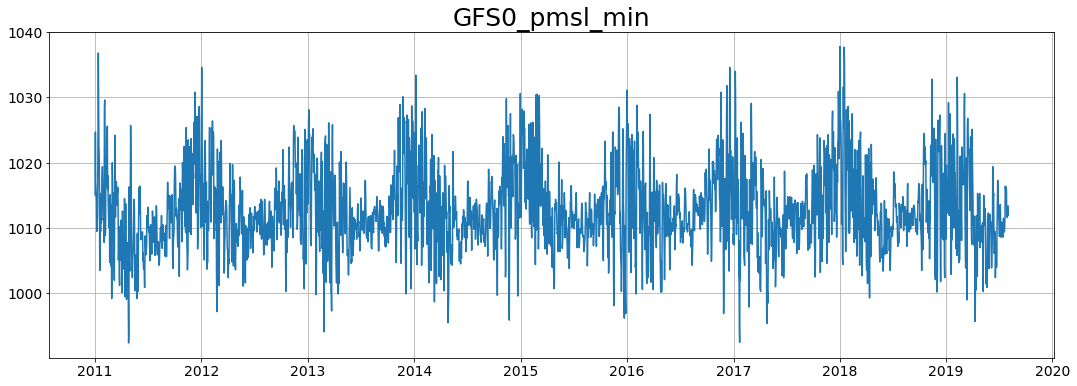

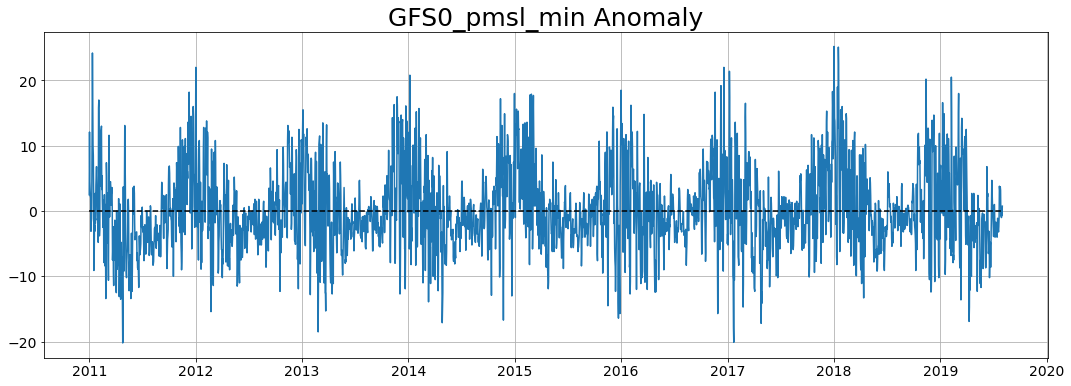

In [ ]:
vary = 'GFS0_pmsl_min'
#dates
dd = total_dataset['date'].reset_index(drop=True) #reseting the index of the pandas dataframe 
converted_dates_1 = list(map(datetime.datetime.strptime, dd, len(dd)*['%Y-%m-%d'])) #Convert the dates 
data_anom = total_dataset[vary].reset_index(drop=True) #grab variable of interest 

#plot the total signal 
f, ax = plt.subplots(figsize=(18, 6)) #add a subplot. 
f.clear()
bb = plt.plot(converted_dates_1[::1],data_anom[::1]) #plotting function
plt.grid(True)
plt.title(vary,fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# plot the anomaly
dd = total_dataset['date'].reset_index(drop=True) #grab the dates
converted_dates_1 = list(map(datetime.datetime.strptime, dd, len(dd)*['%Y-%m-%d']))
data_anom = total_dataset[vary].reset_index(drop=True)-np.mean(total_dataset[vary].reset_index(drop=True)) #remove the mean surface pressure. 
f, ax = plt.subplots(figsize=(18, 6)) #add a subplot. 
f.clear()
bb = plt.plot(converted_dates_1[::1],data_anom[::1]) #plotting function
plt.plot([converted_dates_1[0],converted_dates_1[-1]],[0,0],'k',linestyle='--') #add a zero line
plt.grid(True)
plt.title(vary+' Anomaly',fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Linear Models and Model Training

Let's learn about some linear modeling

## Linear Regression

Linear regression fits the following equation to the training data.

$\hat{y} = \beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j \;\;\;\;\;\; (1)$

$x$: Predictor variable

$M$: Number of predictor variables

$\beta$: Coefficient for predictor variable

$\beta_0$: Bias coefficient/intercept

$\hat{y}$: Predicted label value



**Let's pretend that an analytical solution to minimizing MSE does not exist ($\beta = (X'X)^{-1}X'y$)**



***
The coefficient terms, $\beta$ and $\beta_0$ are adjusted during training to minimize the mean square error (MSE) between the predicted  label $\hat{y}$ and true label $y$. 

$\textrm{MSE} = \frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2 \;\;\;\;\;\; (2)$

$N$: Number of training data


<img src="https://www.oreilly.com/library/view/hands-on-machine-learning/9781788992282/assets/f697bcbb-fb33-4890-ac54-240e7c0c94a7.png
" width="400">


-image credit (https://www.oreilly.com/library/view/hands-on-machine-learning/9781788992282/3da539f8-3925-47d7-b3dd-61ae8420c8e8.xhtml)


<br> 

Combining equations $(1)$ and $(2)$ equations via $\hat{y}$ term yields:

$\textrm{MSE} = \frac{1}{N} \sum\limits_{i = 1}^{N} (\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_{ij} - y_i)^2 \;\;\;\;\;\; (3)$

**We want are $\beta$ and $\beta_0$ values that result in predicted values $\hat{y}$  closest to the true label  ${y}$.**


<br>

To do this, we take the derivative of each coefficient with respect to the MSE equation and minimize this value. Linear regression is sometimes referred to **least-squares linear regression**!!

The derivatives of model coefficients with respect to MSE are as follows.


**-hint-** remember the chain rule for derivatives: $\:\:[f(g(x))]' = f'(g(x))*g(x)'$ 


$\frac{\partial}{\partial \beta_0}(\textrm{MSE}) = \frac{2}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$


$\frac{\partial}{\partial \beta_j}(\textrm{MSE}) = \frac{2}{N} \sum\limits_{i = 1}^{N} x_{ij} (\hat{y}_i - y_i)$

where $\hat{y}$ is defined in $(1)$

The coefficients are updated throughout training by: 

$\beta_0 \leftarrow \beta_0 - \alpha \frac{\partial}{\partial \beta_0}(\textrm{MSE})$

$\beta_j \leftarrow \beta_j - \alpha \frac{\partial}{\partial \beta_j}(\textrm{MSE})$


$\alpha$: Gradient descent parameter (how much do you want to change the coefficients at each update iteration)


<img src="https://bs-uploads.toptal.io/blackfish-uploads/uploaded_file/file/238279/image-1587548990037-a9dc244b868173eb48df437eedc72910.gif" width="900">


With the above mentioned tool boxes, it is VERY easy to fit a linear regression model. 





## Fit your first linear model with SKLEARN

Coeffiecients: [-13.73897102  -8.13450229   1.39412342   0.61368899  -0.20407075]
Intercept: 77.74820172009382


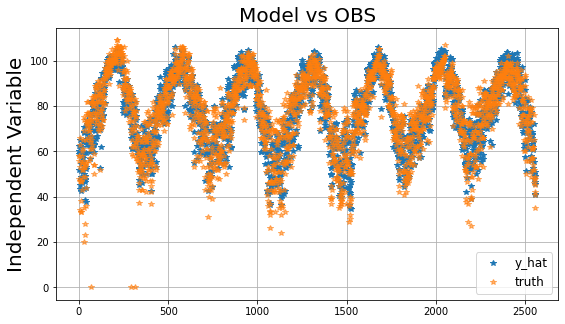

In [ ]:
#scale the input parameters. to help with interpretation. 
tfit = (pca_train_features-np.mean(pca_train_features,axis=0))/np.std(pca_train_features,axis=0)

linreg_model = LinearRegression() #grab the linear regression module from the SKLEARN package
# High Temperature Model
high_temp_linreg = linreg_model.fit(tfit,train_labels['OBS_tmpf_max'].values)
print('Coeffiecients:',high_temp_linreg.coef_)
print('Intercept:',high_temp_linreg.intercept_)

#how does our fit look? THIS IS OUR MODEL! 
plt.figure(figsize=(9,5))
plt.plot(np.matmul(tfit,high_temp_linreg.coef_)+high_temp_linreg.intercept_,'*',label='y_hat') #this is how you get your prediction back! 
plt.plot(train_labels['OBS_tmpf_max'].values,'*',label='truth',alpha=0.6)
plt.grid(True)
plt.title('Model vs OBS',fontsize=20)
plt.ylabel('residual',fontsize=20)
plt.ylabel('Independent Variable',fontsize=20)
plt.legend(fontsize=12)
plt.show()

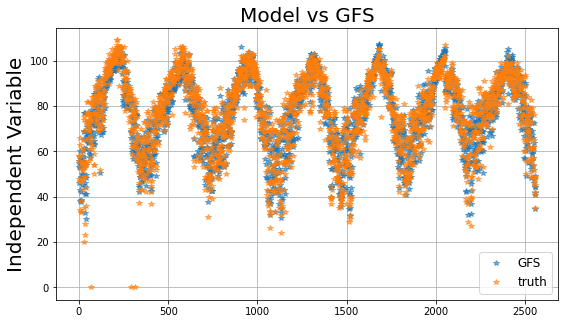

In [ ]:
no_outlier_train_features['GFS0_tf_max']

plt.figure(figsize=(9,5))
plt.plot(no_outlier_train_features['GFS0_tf_max'].values,'*',label='GFS',alpha=0.6)
plt.plot(train_labels['OBS_tmpf_max'].values,'*',label='truth',alpha=0.6)

plt.grid(True)
plt.title('Model vs GFS',fontsize=20)
plt.ylabel('residual',fontsize=20)
plt.ylabel('Independent Variable',fontsize=20)
plt.legend(fontsize=12)
plt.show()

In [ ]:
print('error in the GFS:')
print(np.sqrt(mean_squared_error(no_outlier_train_features['GFS0_tf_max'].values.squeeze(),train_labels['OBS_tmpf_max'].values.squeeze())),'F')

error in the GFS:
5.1525449991312104 F


In [ ]:
print('error in our Linear Model:')
print(np.sqrt(mean_squared_error(np.matmul(tfit,high_temp_linreg.coef_)+high_temp_linreg.intercept_,train_labels['OBS_tmpf_max'].values.squeeze())),'F')

error in our Linear Model:
5.129589924515959 F


## Residuals plot

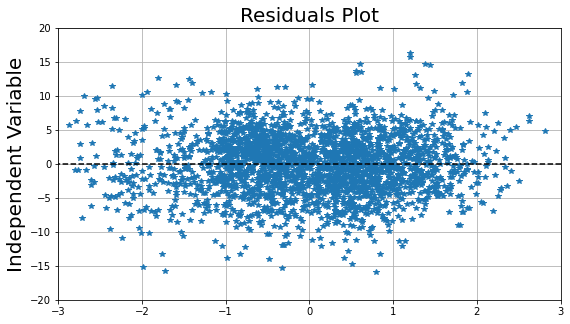

In [ ]:
yhat_sub = np.matmul(tfit,high_temp_linreg.coef_) + high_temp_linreg.intercept_
truth = train_labels['OBS_tmpf_max'].values
resids = yhat_sub-truth
plt.figure(figsize=(9,5))
plt.plot(tfit[:,4],resids,'*') #which feature? change the value in tfit
plt.ylim([-20,20])
plt.xlim([-3,3])

plt.grid(True)
plt.plot([-10,20],[0,0],'k',linestyle='--') #add a zero line
plt.title('Residuals Plot',fontsize=20)
plt.ylabel('residual',fontsize=20)
plt.ylabel('Independent Variable',fontsize=20)
plt.show()

In [ ]:
# plt.figure(figsize=(9,5))
# plt.plot(np.matmul(pca_train_features,high_temp_linreg.coef_)+high_temp_linreg.intercept_)
# plt.plot(train_labels['OBS_tmpf_max'].values)
# plt.show()

# Let's Plot our Linear Fit

In [ ]:
# plt.figure(figsize=(9,5))
# plt.plot(pca_train_features[:,0],train_labels['OBS_tmpf_max'].values,'*')
# plt.plot(pca_train_features[:,0],np.matmul(pca_train_features,high_temp_linreg.coef_)+high_temp_linreg.intercept_,'*')
# plt.grid(True)
# plt.show()

#Train / Test Split



In Machine learning we want to know if the models we develop **generalize well.** Therefore it is CRUCIAL to test your algorithms on data that they have never seen before. 



## Example Problem
### 36-month lead. Nino3.4 prediction


<img src="https://miro.medium.com/max/1326/1*VnhfGJ2Q5Ht_R2cMYM9K9Q.png" width="900">



Let's take a quick sojourn to explore the world of splitting testing/trianing data. For this next section we will leverage the Nino3.4 data set and I would like to credit Ankur Mahesh and his tutorial ([link](https://sites.google.com/lbl.gov/ml4egs/colab-notebooks/notebooks-2019?authuser=0)). We are going to quickly explore Nino3.4 index prediction.

In [ ]:
#Ankur wrote this code for the data ingest and fit
def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time, 
                                    use_pca=False, n_components=32):
  """
  inputs
  ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date 
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

  """
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]
  
  #sst is a 3D array: (time_steps, lat, lon)
  #in this tutorial, we will not be using ML models that take
  #advantage of the spatial nature of global temperature
  #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
  #(At each time step, there are lat*lon predictors)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  #Use Principal Components Analysis, also called
  #Empirical Orthogonal Functions, to reduce the
  #dimensionality of the array
  if use_pca:
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead, 
                                end_date_plus_lead)]


  ds.close()
  return X, y

def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.figure(figsize=(15,5))
  plt.plot(y, label='Ground Truth',linewidth=3,color='k')
  plt.plot(predictions, '--', label='ML Predictions',linewidth=2,color='r')
  plt.legend(loc='best',fontsize=14)
  plt.title(title)
  plt.ylabel('Nino3.4 Index',fontsize=16)
  plt.xlabel('Date',fontsize=16)
  plt.grid(True)
  plt.show()
  plt.close()

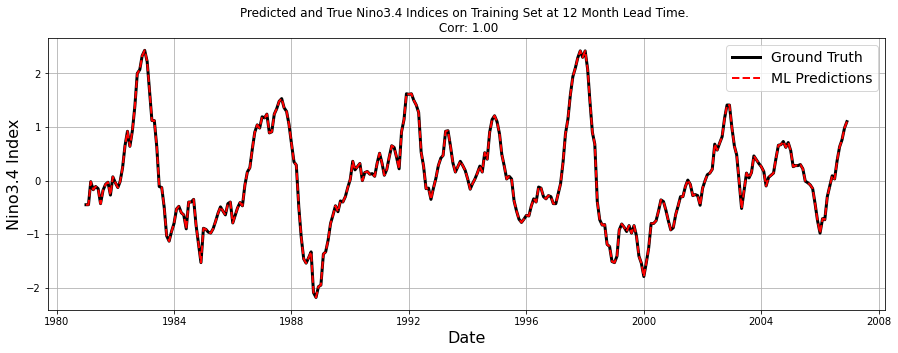

In [ ]:
#Load in the predictors
X, y = assemble_predictors_predictands('1980-01-01','2005-12-31', 12)

#Let's use a linear regression model
regr = LinearRegression()
regr.fit(X,y)

predictions = regr.predict(X)
corr, _ = scipy.stats.pearsonr(predictions, y)

plot_nino_time_series(y, predictions, 
    'Predicted and True Nino3.4 Indices on Training Set at 12 Month Lead Time. \n Corr: {:.2f}'.format(corr))



This seems to be a perfect fit!!! But how does it perform on data that it has never seen before? This way we can tell if our model generalizes well. 

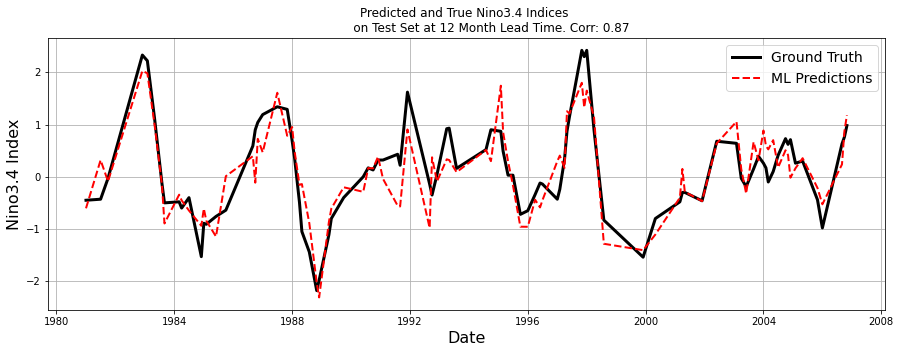

In [ ]:
"""Evaluate the model on a randomly selected test set"""
#X has shape (num_time_steps, lat*lon)
#y has shape (num_time_steps)
np.random.seed(0)

#Randomly shuffle X and y to split them in a train and test set
num_time_steps = X.shape[0]
permuted_indices = np.random.permutation(np.arange(num_time_steps))

#Keep 70% of the data for the test set
train_set_proportion = int(0.7 * num_time_steps)
X, y = X[permuted_indices], y[permuted_indices]
X_train, y_train = X[:train_set_proportion], y[:train_set_proportion]
X_test, y_test = X[train_set_proportion:], y[train_set_proportion:]

#Instead of writing the above logic yourself, sklearn also provides
#a built-in method in the line below.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
regr = LinearRegression()
regr.fit(X_train,y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 12 Month Lead Time. Corr: {:.2f}'.format(corr))

**Did** we just solve the Nino3.4 Prediction problem?!?!?! ... did that seem too easy???  

**BIG PROBLEM**. Randomly splitting time series data into a train set and a test set is very risky. In many climate datasets, time series have a non-neglible auto-correlation.

If we randomly split the dataset into train set and test set, some of the examples in the test set will be correlated with examples in the train set.  **This corrupts our test set.** If the test set is correlated with the train set, then it no longer measures how generalizable our ML model is.


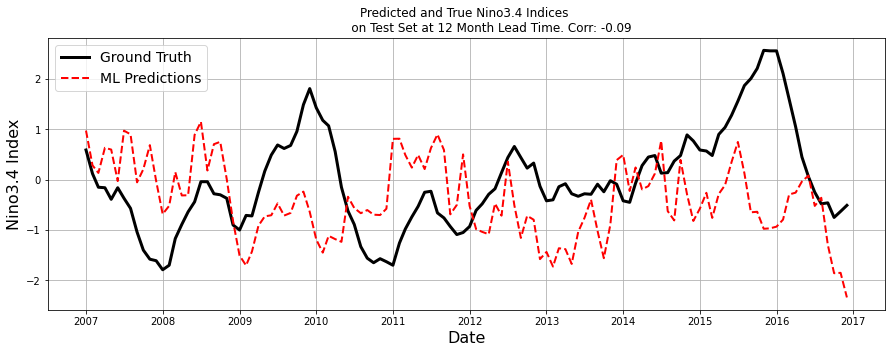

In [ ]:
"""Instead, Evaluate the model on time-split data"""

#This time we will seperate by date: 
#Load in the predictors
X_train, y_train = assemble_predictors_predictands('1990-01-01','2005-12-31', 12)
X_test, y_test = assemble_predictors_predictands('2006-01-01','2015-12-31', 12)

regr = LinearRegression()
regr.fit(X_train,y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 12 Month Lead Time. Corr: {:.2f}'.format(corr))

That's better ... the world makes sense again.

## Hyperparameter Tuning

### **Cross-Validation**
  - Break up the training dataset into multiple **folds**, where a certain number are used to **fit** or **train** the ML model and a single fold (not used in training) **validates** the model (essentially testing the model)
  - Repeat this procedure of breaking up training data into training/validation folds until every data fold is used for validation
  - The trained ML model with the highest validation score of all the different training/validation pairs is evaluated on the testing data
    - **Testing data is never used in training the model, only for evaluating a model already trained**


The easiest way to do this in python is with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

<img src="https://docs.google.com/uc?export=download&id=1Llru509goS8OA3irMXEmoCoDMDPVhUvS" height= "400">






### **Validation**

  - What if you don't want to use the python models out-of-the-box, but instead change the **hyperparameters** to better fit your data?

  - Hyperparameters: user-defined parameters that constrain a model to speed up learning and/or prevent overfitting (McGovern et al. 2020) 


<img src="https://miro.medium.com/max/875/1*_7OPgojau8hkiPUiHoGK_w.png" width="600">


  - Two (main) possibilities: 
    - Create a third independent subset for tuning hyperparameters, called  **validation dataset** 
    - Use cross-validation on the already divided training data if dataset is small

## Fit Some Models 

Using our scaled data without outliers, train the LinearRegression (LinReg) model out-of-the-box (no change in hyperparameters)

*We will have different LinReg models predicting the high temperature, low temperature, and wind speed.* 

In [ ]:
linreg_model = LinearRegression()
# High Temperature Model
high_temp_linreg = linreg_model.fit(pca_train_features,train_labels['OBS_tmpf_max'].values)

linreg_model = LinearRegression()
# Low Temperature Model
low_temp_linreg = linreg_model.fit(pca_train_features,train_labels['OBS_tmpf_min'].values)

wind_linreg_model = LinearRegression()
# Max Wind Speed Model
wind_linreg = wind_linreg_model.fit(pca_train_features,train_labels['OBS_sknt_max'].values)

In [ ]:
#let's look at our coefficients (Beta)
print(wind_linreg.coef_)

[-0.17507383  0.61985143  0.21898238  1.50632692  0.21247608]


In [ ]:
#let's look at our intercept (Beta_o)
print(wind_linreg.intercept_)

16.045343706020326


## Evaluating the Model Fit

Some common evaluation metrics used with regression problems are: 

Mean absolute error (MAE): $\frac{1}{N} \sum\limits_{i = 1}^{N} \lvert \hat{y}_i - y_i \rvert$

Mean squared error (MSE): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$

Mean signed error ("bias"): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$

MAE skill score: $\frac{\textrm{MAE}_{\textrm{climo}} - \textrm{MAE}}{\textrm{MAE}_{\textrm{climo}}}$

-  $\textrm{MAE}_{\textrm{climo}}$ is the average training MAE


More evalution metrics can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html). 

Again, these functions are built in and ready to use. 

Mean square error: 40.915779181529686

Predicted values 
[54.97655249 60.1043288  58.06681005 51.26700635 47.80906082 46.62950367
 61.6359693  65.07925669 54.34725561 46.37451073]

Actual values 
[54.  60.1 66.  46.  44.1 50.  61.  72.  60.1 43. ]


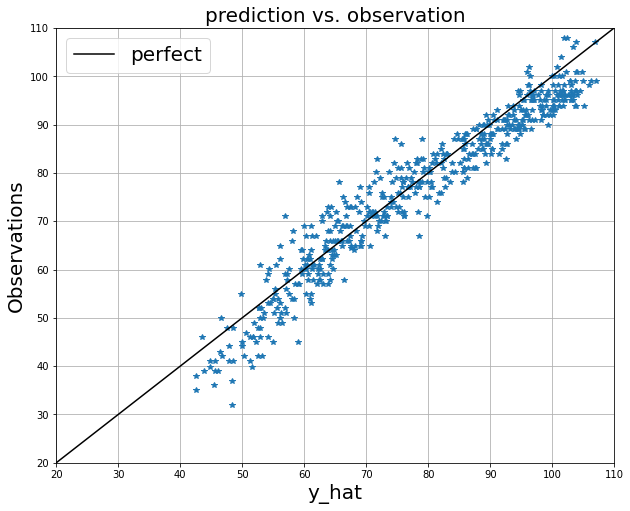

In [ ]:
high_temp_y_pred = high_temp_linreg.predict(pca_test_features)
high_temp_mse = mean_squared_error(high_temp_y_pred,test_labels['OBS_tmpf_max'].values)

print(f'Mean square error: {high_temp_mse}')
print(f'\nPredicted values \n{high_temp_y_pred[:10]}')
print(f'\nActual values \n{test_labels["OBS_tmpf_max"].values[:10] }')

plt.figure(figsize=(10,8))
plt.plot(high_temp_y_pred,test_labels['OBS_tmpf_max'].values,'*')
plt.xlim([20,110])
plt.ylim([20,110])
plt.grid(True)
plt.title('prediction vs. observation',fontsize=20)
plt.ylabel('Observations',fontsize=20)
plt.xlabel('y_hat',fontsize=20)
plt.plot([20,110],[20,110],color='k',label='perfect')
plt.legend(fontsize=20)
plt.show()

An additional verification/evaluation metric is the **reliability curve** 
- Shows model bias with respect to a conditional mean observation for each forecasted value
- What is the mean observed value for a given range of forecast values
- Data points above the 1-1 line are underforecasting, points under the line are overforecasting

In [ ]:
 def regression_reliability_curve(forecasts,observations,nbins=20):
  step = (np.nanmax(forecasts)-np.nanmin(forecasts))/nbins
  bins = np.arange(np.nanmin(forecasts),np.nanmax(forecasts),step)

  mean_forecast = np.empty( (np.shape(bins)) )*np.nan
  mean_obs = np.empty( (np.shape(bins)) )*np.nan

  # For each bin, find the mean forecast value and observation
  for b,bin in enumerate(bins[:-1]):
    bin_indices = np.where((forecasts >= bin) & (forecasts < bins[b+1]))[0]
    mean_forecast[b] = np.nanmean(forecasts[bin_indices])
    mean_obs[b] = np.nanmean(observations[bin_indices])

  #Get maximum value of both datasets to plot
  max_value = np.nanmax( [np.nanmax(forecasts) , np.nanmax(observations)] )
  perfect_values = np.arange(0.,max_value)

  plt.figure(figsize=(8,8))
  #Plotting 1-1 liness
  plt.plot(perfect_values,perfect_values,linestyle='dashed',color='k')
  #Plotting mean forecast values versus the mean observations
  plt.plot(mean_forecast,mean_obs,'s',markersize=10)
  plt.ylabel('Conditional Mean Observation',fontsize=16)
  plt.xlabel('Forecast value',fontsize=16)
  plt.title('Reliability Curve',fontsize=18)
  plt.grid(True)
  plt.show()
  return

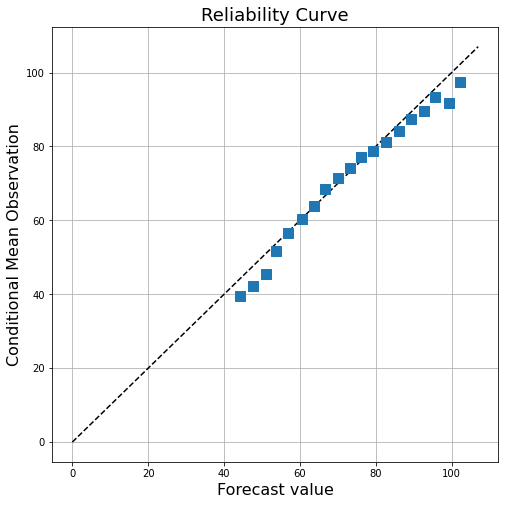

In [ ]:
regression_reliability_curve(high_temp_y_pred, test_labels['OBS_tmpf_max'].values, nbins=20)

# Bias / Variance trade off - Linear Feature Selection - and - Lasso Regression 
[link text](https:// [link text](https://))

for $Y = f(X) + e$ and e is normally distributed error $e = N(o,\sigma_e)$

First let's examine and deconstruct expected squared prediction error: 

$Err(x) = E[(Y -\hat f(x))^2]$

For the decomposition math please see this reference: [link](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html)


$Err(x) = \mathbf{(E[\hat f(x)]- f(x))^2} + \mathbf{E[(\hat f(x) - E[\hat f(x)])^2]} + \mathbf{\sigma_e^2} $

$Err(x)=Bias^2 + Variance + Irreducible Error$


There is a trade-off on a models ability to reduce error in the bias and variance terms. 


<img src="https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/images/bias_variance/bullseye.png" height= "600">

-image credit <http://scott.fortmann-roe.com/docs/BiasVariance.html>


**Bias**: What is the inherent error that you obtain from your model even with infinite training data? This is due to your model being "biased" to a particular kind of solution. In other words, bias is inherent to your model.

The error due to bias is taken as the difference between the expected (or average) prediction of our model and the correct value which we are trying to predict. Of course you only have one model so talking about expected or average prediction values might seem a little strange. However, imagine you could repeat the whole model building process more than once: each time you gather new data and run a new analysis creating a new model. Due to randomness in the underlying data sets, the resulting models will have a range of predictions. Bias measures how far off in general these models' predictions are from the correct value.

**Variance**: Captures how much your model results change if you train on a different training set. How "over-specialized" is your model to a particular training set (overfitting)? If we have the best possible model for our training data, how far off are we from the average classifier?

The error due to variance is taken as the variability of a model prediction for a given data point. Again, imagine you can repeat the entire model building process multiple times. The variance is how much the predictions for a given point vary between different realizations of the model.


**Irreducible Error/Noise**: How big is the data-intrinsic noise? This error measures ambiguity due to your data distribution and feature representation. You can never beat this, it is an aspect of the data.

https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html


Managing bias and variance is really about dealing with over- and under-fitting. Bias is reduced and variance is increased in relation to model complexity. As more and more parameters are added to a model, the complexity of the model rises and variance becomes our primary concern while bias steadily falls. For example, as more polynomial terms are added to a linear regression, the greater the resulting model's complexity will be. In other words, bias has a negative first-order derivative in response to model complexity while variance has a positive slope.


- credit [paper](http://scott.fortmann-roe.com/docs/BiasVariance.html)


Here is a quick coding excersize to show this. A big thank you to [This Blog](https://dustinstansbury.github.io/theclevermachine/bias-variance-tradeoff) from which this code was pulled.

### We have some data (black circles) that is drawn from a noisy sine function

However ... we don't know the underlying distribution (sine wave), let's use the data to try to find a good "fit"

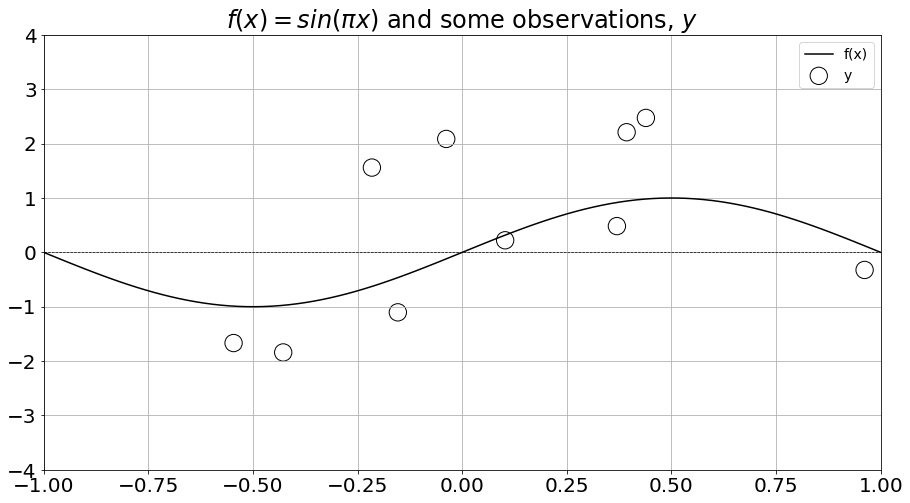

In [ ]:
np.random.seed(123) #random seed
MARKER_SIZE = 300 #plotting plotting setting
DATA_COLOR = 'black' #plotting setting
ERROR_COLOR = 'darkred' #plotting setting
POLYNOMIAL_FIT_COLORS = ['orange', 'royalblue', 'darkgreen'] #plotting setting
N_OBSERVATIONS = 10 #number of 'observations' to take
NOISE_STD = 1 #noise in your observations 

x = 2 * (np.random.rand(N_OBSERVATIONS) - .5) #x variables "resposne"
x_grid = np.linspace(-1, 1, 100)

def f(x):
    """Base function"""
    return np.sin(x * np.pi)

def sample_fx_data(shape, noise_std=NOISE_STD):
    return f(x) + np.random.randn(*shape) * noise_std


def plot_fx_data(y=None):
    """Plot f(x) and noisy samples"""
    y = y if y is not None else sample_fx_data(x.shape)
    fig, axs = plt.subplots(figsize=(15, 8))
    plt.plot(x_grid, f(x_grid), color=DATA_COLOR, label='f(x)')
    plt.scatter(x, y, s=MARKER_SIZE, edgecolor=DATA_COLOR, facecolors='none', label='y')


# Plot the data
y = sample_fx_data(x.shape) # this is creating the black circles
plot_fx_data(y)# this is plotting the black circles + the sin curve. 
plt.legend(fontsize=14)
plt.title(f'$f(x) = sin(\pi x)$ and some observations, $y$', fontsize=24)
plt.xlim([-1, 1])
plt.ylim([-4, 4])
plt.plot([-1,1],[0,0],color='k',linestyle='--',linewidth=0.7)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()

## Example: Let's fit models of varying complexity to this data. 

We will do this by fitting polynomial functions of varying size. I.E. 

For an estimation of function $f(x)$ we will use:


$\hat f(x) = \theta_0 + \theta_1 x + \theta_1 x^2 + ... +  \theta_1 x^D$ 


Let's first examine the fits: $D = [1 , 3, 10]$


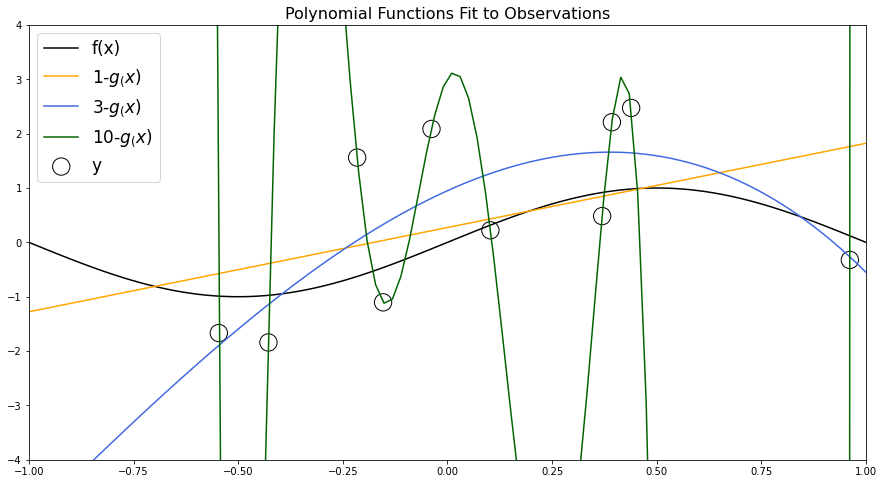

In [ ]:
plot_fx_data(y)
polynomial_degrees = [1, 3, 10]
theta = {}
fit = {}
for ii, degree in enumerate(polynomial_degrees):
    # Note: we should get an overconditioned warning for degree 10 because of extreme overfitting
    theta[degree] = np.polyfit(x, y, degree)
    fit[degree] = np.polyval(theta[degree], x_grid)
    plt.plot(x_grid, fit[degree], POLYNOMIAL_FIT_COLORS[ii], label=str(degree) +'-'+ f"$g_(x)$")
plt.legend(fontsize=17)
plt.xlim([-1, 1])
plt.ylim([-4, 4])
plt.title("Polynomial Functions Fit to Observations", fontsize=16)
plt.show()

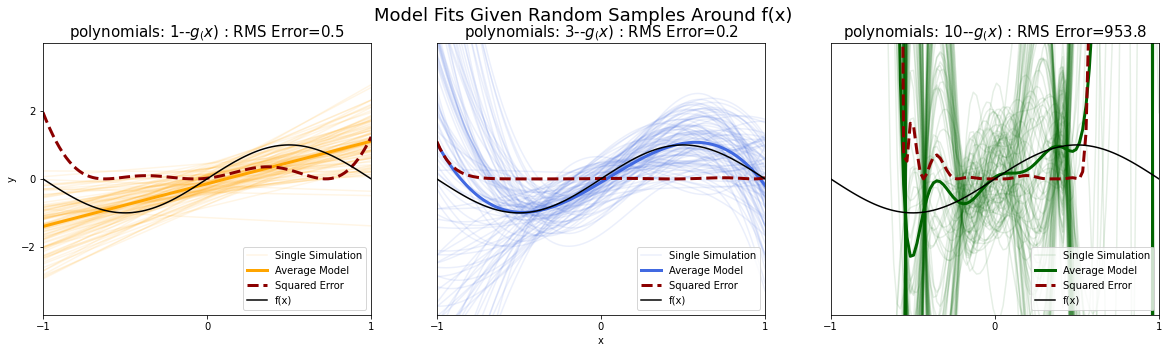

In [ ]:
from collections import defaultdict
polynomial_degrees = [1, 3, 10]

n_simulations = 100
simulation_fits = defaultdict(list)
for sim in range(n_simulations):
    # Start from same samples
    y_simulation = sample_fx_data(x.shape)
    for degree in polynomial_degrees:
        theta_tmp = np.polyfit(x, y_simulation, degree)
        simulation_fits[degree].append(np.polyval(theta_tmp, x_grid))

def error_function(pred, actual):
    return (pred - actual) ** 2

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for ii, degree in enumerate(polynomial_degrees):
    plt.sca(axs[ii])
    for jj, fit in enumerate(simulation_fits[degree]):
        label = 'Single Simulation' if jj == 0 else None
        plt.plot(x_grid, fit, color=POLYNOMIAL_FIT_COLORS[ii], alpha=.1, label=label)

    average_fit = np.array(simulation_fits[degree]).mean(0)
    squared_error = error_function(average_fit, f(x_grid))
    rms = np.sqrt(np.mean(squared_error))
    plt.plot(x_grid, average_fit, color=POLYNOMIAL_FIT_COLORS[ii], linewidth=3, label='Average Model')
    plt.plot(x_grid, squared_error, '--', color=ERROR_COLOR, label='Squared Error',linewidth=3)
    plt.plot(x_grid, f(x_grid), color='black', label='f(x)')
    plt.yticks([])
    if ii == 1:
        plt.xlabel('x')
    elif ii == 0:
        plt.ylabel('y')
        plt.yticks([-2, 0, 2])

    plt.xlim([-1, 1])
    plt.ylim([-4, 4])
    plt.xticks([-1, 0, 1])
    plt.title('polynomials: '+str(degree)+'--'+f"$g_(x)$ : RMS Error={np.round(rms, 1)}",fontsize=15)
    plt.legend(loc='lower right')
plt.suptitle('Model Fits Given Random Samples Around f(x)', fontsize=18)
plt.show()

Now let's assess the bias variance tradeoff in models of varying size using an independent testing data set.

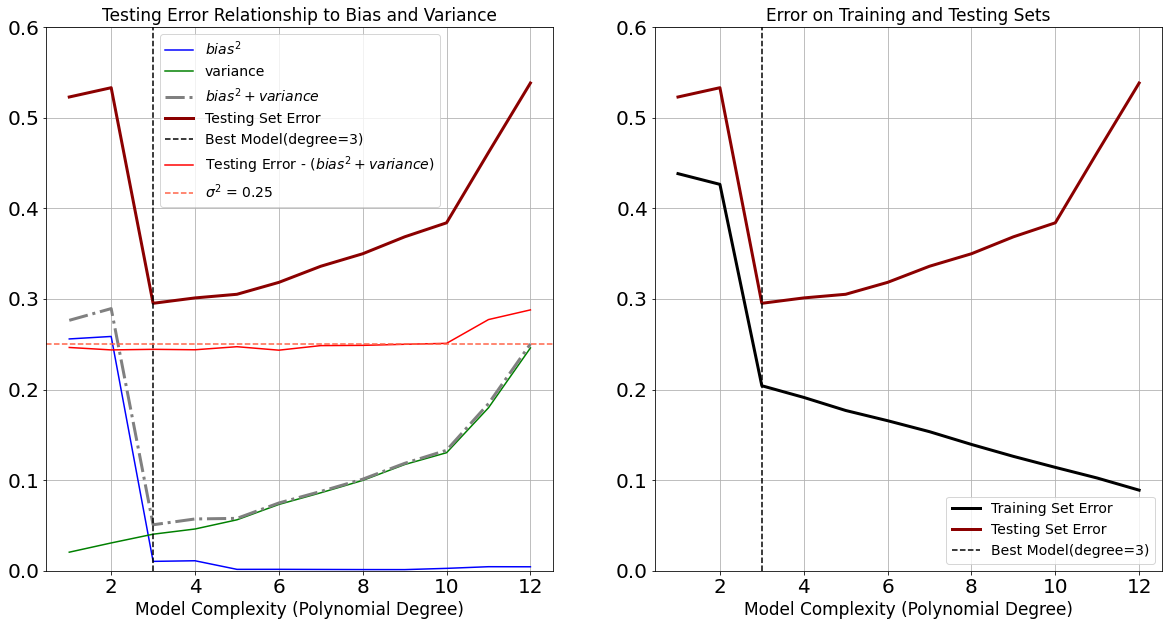

In [ ]:
np.random.seed(124)
n_observations_per_dataset = 25
n_datasets = 100
max_poly_degree = 12  # Maximum model complexity
model_poly_degrees = range(1, max_poly_degree + 1)

NOISE_STD = .5
percent_train = .8
n_train = int(np.ceil(n_observations_per_dataset * percent_train))

# Create training/testing inputs
x = np.linspace(-1, 1, n_observations_per_dataset)
x = np.random.permutation(x)
x_train = x[:n_train]
x_test = x[n_train:]

# logging variables
theta_hat = defaultdict(list)

pred_train = defaultdict(list)
pred_test = defaultdict(list)

train_errors = defaultdict(list)
test_errors = defaultdict(list)

# Loop over datasets
for dataset in range(n_datasets):

    # Simulate training/testing targets
    y_train = f(x_train) + NOISE_STD * np.random.randn(*x_train.shape)
    y_test = f(x_test) + NOISE_STD * np.random.randn(*x_test.shape)

    # Loop over model complexities
    for degree in model_poly_degrees:
        # Train model
        tmp_theta_hat = np.polyfit(x_train, y_train, degree)
        # Make predictions on train set
        tmp_pred_train = np.polyval(tmp_theta_hat, x_train)
        pred_train[degree].append(tmp_pred_train)

        # Test predictions
        tmp_pred_test = np.polyval(tmp_theta_hat, x_test)
        pred_test[degree].append(tmp_pred_test)

        # Mean Squared Error for train and test sets
        train_errors[degree].append(np.mean(error_function(tmp_pred_train, y_train)))
        test_errors[degree].append(np.mean(error_function(tmp_pred_test, y_test)))


def calculate_estimator_bias_squared(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]
    # (E[g(x)] - f(x))^2, averaged across all trials
    return np.mean((average_model_prediction - f(x_test)) ** 2)


def calculate_estimator_variance(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]
    # (g(x) - E[g(x)])^2, averaged across all trials
    return np.mean((pred_test - average_model_prediction) ** 2)

complexity_train_error = []
complexity_test_error = []
bias_squared = []
variance = []
for degree in model_poly_degrees:
    complexity_train_error.append(np.mean(train_errors[degree]))
    complexity_test_error.append(np.mean(test_errors[degree]))
    bias_squared.append(calculate_estimator_bias_squared(pred_test[degree]))
    variance.append(calculate_estimator_variance(pred_test[degree]))

best_model_degree = model_poly_degrees[np.argmin(complexity_test_error)]

# Visualizations
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

## Plot Bias^2 + variance
plt.sca(axs[0])
plt.plot(model_poly_degrees, bias_squared, color='blue', label='$bias^2$')
plt.plot(model_poly_degrees, variance, color='green', label='variance')
plt.plot(model_poly_degrees, np.array(bias_squared) + np.array(variance),  linestyle='-.', color='gray', label='$bias^2 + variance$',linewidth=3)
plt.plot(model_poly_degrees, complexity_test_error, label='Testing Set Error', linewidth=3, color=ERROR_COLOR)
plt.axvline(best_model_degree, linestyle='--', color='black', label=f'Best Model(degree={best_model_degree})')
plt.plot(model_poly_degrees, np.array(complexity_test_error) - (np.array(bias_squared) + np.array(variance)), color='red', label='Testing Error - ($bias^2 + variance$)')
plt.axhline(NOISE_STD **2, color='tomato', linestyle='--', label=f'$\sigma^2$ = {round(NOISE_STD**2, 3)}')
plt.legend(fontsize=14)
plt.xlabel('Model Complexity (Polynomial Degree)',fontsize=17)
plt.ylim([0, .6]);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

plt.title('Testing Error Relationship to Bias and Variance',fontsize=17)

## Plot Train / Test Set Error
plt.sca(axs[1])
plt.plot(model_poly_degrees, complexity_train_error, label='Training Set Error', linewidth=3, color=DATA_COLOR)
plt.plot(model_poly_degrees, complexity_test_error, label='Testing Set Error', linewidth=3, color=ERROR_COLOR)
plt.axvline(best_model_degree, linestyle='--', color='black', label=f'Best Model(degree={best_model_degree})')
plt.ylim([0, .6]);
plt.xlabel('Model Complexity (Polynomial Degree)',fontsize=17)
plt.title('Error on Training and Testing Sets',fontsize=17)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

Take away:
*   models that are too complex will have high variance and low bias
*   models that are too simple will have high bias and low variance.
*   The best model will have both low bias and low variance. - play with complexity, and USE YOUR VALIDATION DATASETS

## Regularization

For a full mathematical demonstration of l2 (ridge) and l1 (lasso) regularization see this reference: [link](https://www.mit.edu/~9.520/spring09/Classes/class11_sparsity.pdf) 


Regularization is a powerful tool to cut down on unecessary model complexity and can be used for feature selection. The idea is very simple, we will add a "penalty" term, which encourages the model to cut down on complexity (thus "awarding" bias and ensuring low variance.) We are combatting over-fitting!

Let's look at an example by fitting a line to data: 

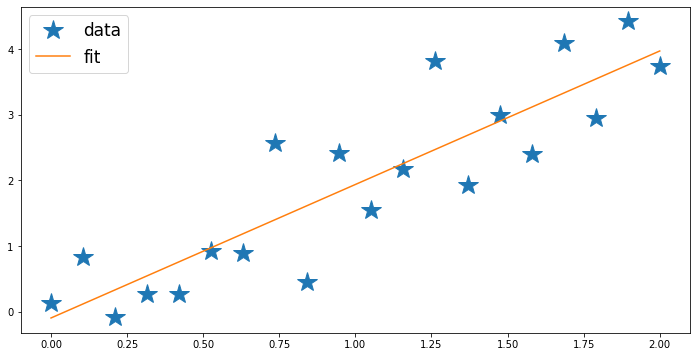

model error: 8.763688005781578


In [ ]:
np.random.seed(25)
def xfunc(x): 
  return 2*x + np.random.randn(x.shape[0])*0.6

x = np.linspace(0,2,num=20)
y = xfunc(x)

linreg_model = LinearRegression()
mod = linreg_model.fit(np.expand_dims(x,axis=1),y)
#get the slope and the intercept and plot the line. 

plt.figure(figsize=(12,6))
plt.plot(x,y,'*',markersize=20,label ='data')
yhat = x*mod.coef_ + mod.intercept_
plt.plot(x,yhat,label ='fit')
plt.legend(fontsize=17)
plt.show()

def error_function(pred, actual):
    return (pred - actual) ** 2
print('model error:',np.sum(error_function(yhat,y)) )

*But* what if we only have two of those data points in our training? Let's sub-sample and fit a line

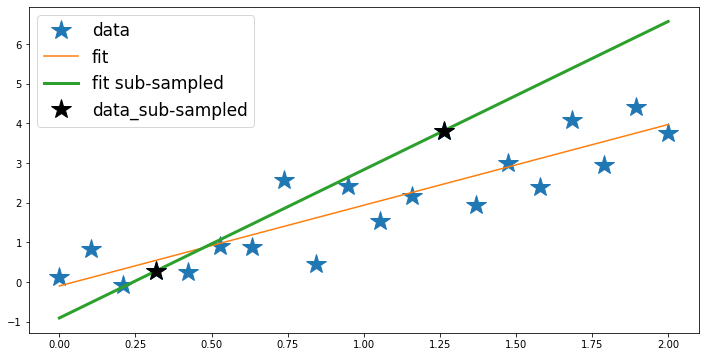

error in training: 2.465190328815662e-31
error in testing: 46.17803903954104


In [ ]:
#subsample the data:
x_sub = np.array([x[3],x[12]])
y_sub = np.array([y[3],y[12]])


mod_sub = linreg_model.fit(np.expand_dims(x_sub,axis=1),y_sub)
plt.figure(figsize=(12,6))
plt.plot(x,y,'*',markersize=20,label ='data')
yhat_sub = x*mod_sub.coef_ + mod_sub.intercept_
plt.plot(x,yhat,label ='fit')
plt.plot(x,yhat_sub,label ='fit sub-sampled',linewidth=3)
plt.plot(x_sub,y_sub,'*',color='k',markersize=20,label ='data_sub-sampled')
plt.legend(fontsize=17)
plt.show()


print('error in training:',np.sum(error_function(x_sub*mod_sub.coef_ + mod_sub.intercept_,y_sub)))
print('error in testing:',np.sum(error_function(yhat_sub,y)) )

MSE for training data (red) is = 0, but the MSE for the testing data (blue) is HIGH.

This means that the green line has HIGH variance and is overfit to training data. What we want is to play with the bias / variance trade off so that the line **WILL NOT** fit the training data as well. Thus we want to **INCREASE** bias to cut down on variance. We are hoping to increase bias but significantly decrease variance. Regularization can help us accomplish this. 

In a traditional fit, we want to minimize the **sum of the squared residuals** (see figure above.) when regularizing with L2 (ridge), we want to minimize the **sum of the squared residuals + a term $\lambda * slope^2$**

L2  Function $= \frac{1}{N} \sum\limits_{i = 1}^{N} (\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_{ij} - y_i)^2 +  \lambda \sum\limits_{j = 1}^{M} \beta_j ^2$

This is termed ridge regression

L1  Function $= \frac{1}{N} \sum\limits_{i = 1}^{N} (\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_{ij} - y_i)^2 +  \lambda \sum\limits_{j = 1}^{M}| \beta_j |$

This is termed LASSO regression


the $slope^2$ adds a penalty to the "cost" of fitting a line and $\lambda$ scales that penalty. 


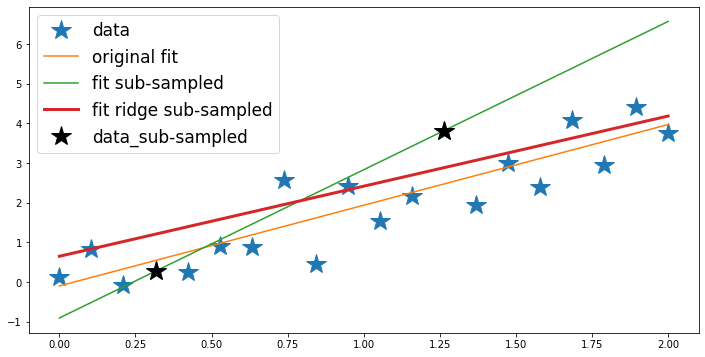

ridge error Training: 1.7414421632414707
ridge error Testing: 13.911155094704712
subset error Testing: 46.17803903954104


In [ ]:
# Fit a ridge regression line:
Ridge_model = Ridge(alpha=1)
mod_sub_ridge = Ridge_model.fit(np.expand_dims(x_sub,axis=1),y_sub)

mod_sub = linreg_model.fit(np.expand_dims(x_sub,axis=1),y_sub)
plt.figure(figsize=(12,6))
plt.plot(x,y,'*',markersize=20,label ='data')
yhat_sub_ridge = x*mod_sub_ridge.coef_ + mod_sub_ridge.intercept_
plt.plot(x,yhat,label ='original fit')
plt.plot(x,yhat_sub,label ='fit sub-sampled')
plt.plot(x,yhat_sub_ridge,label ='fit ridge sub-sampled',linewidth=3)
plt.plot(x_sub,y_sub,'*',color='k',markersize=20,label ='data_sub-sampled')
plt.legend(fontsize=17)
plt.show()


yhat_sub_ridge = x*mod_sub_ridge.coef_ + mod_sub_ridge.intercept_
print('ridge error Training:',np.sum(error_function(x_sub*mod_sub_ridge.coef_ + mod_sub_ridge.intercept_,y_sub)))
print('ridge error Testing:',np.sum(error_function(yhat_sub_ridge,y)))
print('subset error Testing:',np.sum(error_function(yhat_sub,y)))

**Why did the model choose that line**?


In [ ]:
lamb = 1
print('overfit line + penalty error :',np.sum(error_function(x_sub*mod_sub.coef_ + mod_sub.intercept_,y_sub)) + lamb * mod_sub.coef_**2)
print('Ridge line error :',np.sum(error_function(x_sub*mod_sub_ridge.coef_ + mod_sub_ridge.intercept_,y_sub)) + lamb * mod_sub_ridge.coef_**2)

overfit line + penalty error : [13.97230257]
Ridge line error : [4.32794076]



**What do we do with Lamda**?

in this case, by increasing BIAS, the ridge regression significantly decreased variance

In this example, the slope was too sensitive/responsive (small changes in X resulted in very large changes in Y). Ridge regression had a line that had a smaller slope, making sure that it was not as "sensitive" to changes in X. As we increase Lambda, the slope will be even smaller. Thus, the larger lambda gets, the less sensitive the model becomes. This is now a hyper-parameter to "tune" with cross-validation. 


Things we don't have time for:
*   Ridge regression works well with logistic regression and categorical variables, and a mix of both. But we don't have the time to go through this! 
*   Ridge regression can solve the p vs. n problem!

## Lasso (L1) Regression is potentially MORE exciting. 

because it is capable of completely eliminating predictors that are not providing skill 

L1  Function $= \frac{1}{N} \sum\limits_{i = 1}^{N} (\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_{ij} - y_i)^2 +  \lambda \sum\limits_{j = 1}^{M}| \beta_j |$


Big difference... between Lasso and ridge regression is that LASSO can shrink the slope of variables to 0 where ridge can only get the slope close to 0. Thus we can use Lasso regression to eliminate variables in our predictor set. For a nice intuitive treatment of this see this [link](https://stats.stackexchange.com/questions/74542/why-does-the-lasso-provide-variable-selection)


general use cases: 

Use Lasso when you are not sure if variables are important, use Ridge when you are confident that all of your predictor variables are important. 


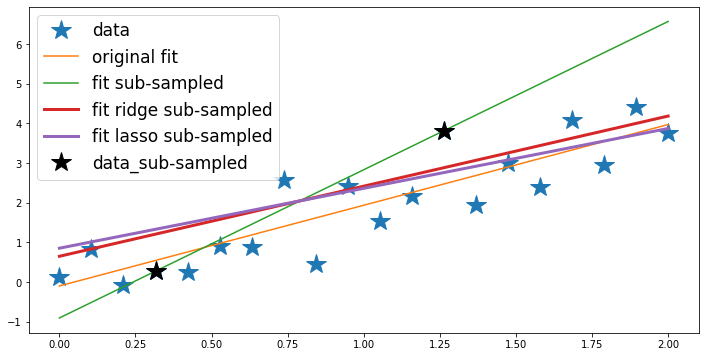

lasso error Training: 2.2283950617283947
ridge error Testing: 13.911155094704712
lasso error Testing: 14.432052759359657
subset error Testing: 46.17803903954104


In [ ]:
# Fit a lasso regression line:
Lasso_model = Lasso(alpha=0.5)
mod_sub_lasso = Lasso_model.fit(np.expand_dims(x_sub,axis=1),y_sub)
plt.figure(figsize=(12,6))
plt.plot(x,y,'*',markersize=20,label ='data')
yhat_sub_lasso = x*mod_sub_lasso.coef_ + mod_sub_lasso.intercept_
plt.plot(x,yhat,label ='original fit')
plt.plot(x,yhat_sub,label ='fit sub-sampled')
plt.plot(x,yhat_sub_ridge,label ='fit ridge sub-sampled',linewidth=3)
plt.plot(x,yhat_sub_lasso,label ='fit lasso sub-sampled',linewidth=3)

plt.plot(x_sub,y_sub,'*',color='k',markersize=20,label ='data_sub-sampled')
plt.legend(fontsize=17)
plt.show()


# yhat_sub_ridge = x*mod_sub_ridge.coef_ + mod_sub_ridge.intercept_
print('lasso error Training:',np.sum(error_function(x_sub*mod_sub_lasso.coef_ + mod_sub_lasso.intercept_,y_sub)))
print('ridge error Testing:',np.sum(error_function(yhat_sub_ridge,y)))
print('lasso error Testing:',np.sum(error_function(yhat_sub_lasso,y)))
print('subset error Testing:',np.sum(error_function(yhat_sub,y)))

In [ ]:
#Ridge regression: 
ridge_model = Ridge(alpha=0.5)

# High Temperature Model
high_temp_ridgereg = ridge_model.fit(pca_train_features,train_labels['OBS_tmpf_max'].values)
high_temp_y_pred = high_temp_ridgereg.predict(pca_test_features)

high_temp_mse = mean_squared_error(high_temp_y_pred,test_labels['OBS_tmpf_max'].values)

print(f'Mean square error: {high_temp_mse}')
print(f'\nPredicted values \n{high_temp_y_pred[:10]}')

print(f'\nActual values \n{test_labels["OBS_tmpf_max"].values[:10] }')

Mean square error: 40.91533834170984

Predicted values 
[54.97670833 60.10449134 58.06699903 51.26725713 47.80942289 46.62981045
 61.63605311 65.07937396 54.34752059 46.37478874]

Actual values 
[54.  60.1 66.  46.  44.1 50.  61.  72.  60.1 43. ]


In [ ]:
#Lasso regression: 
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=0.5)

# High Temperature Model
high_temp_lassoreg = lasso_model.fit(pca_train_features,train_labels['OBS_tmpf_max'].values)
high_temp_y_pred = high_temp_lassoreg.predict(pca_test_features)

high_temp_mse = mean_squared_error(high_temp_y_pred,test_labels['OBS_tmpf_max'].values)

print(f'Mean square error: {high_temp_mse}')
print(f'\nPredicted values \n{high_temp_y_pred[:10]}')

print(f'\nActual values \n{test_labels["OBS_tmpf_max"].values[:10] }')

Mean square error: 40.58219499893939

Predicted values 
[55.27172383 59.93107482 57.89655239 51.27254983 48.29422274 46.7562629
 61.92648063 64.83503612 54.48004375 46.31552737]

Actual values 
[54.  60.1 66.  46.  44.1 50.  61.  72.  60.1 43. ]


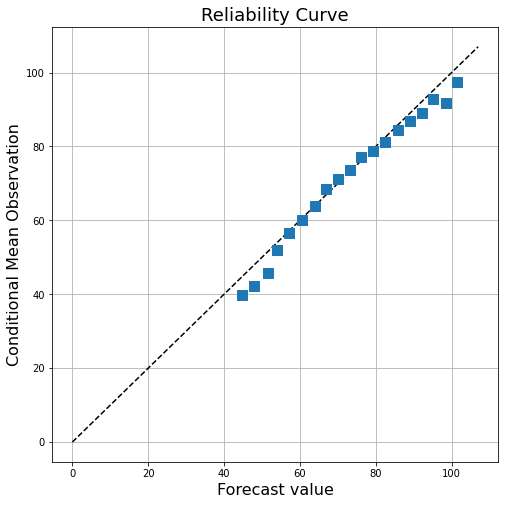

In [ ]:
regression_reliability_curve(high_temp_y_pred, test_labels['OBS_tmpf_max'].values, nbins=20)

### CHECK THE FIT COEFS

In [ ]:
#LASSO
high_temp_lassoreg.coef_

array([-2.72423316, -2.18988957,  0.45038568,  0.17722364, -0.        ])

In [ ]:
#RIDGE
high_temp_ridgereg.coef_

array([-2.74415919, -2.22734523,  0.51991492,  0.28523271, -0.1169133 ])

In [ ]:
#LINEAR
high_temp_linreg.coef_

array([-2.74418059, -2.22737787,  0.51992905,  0.28524475, -0.1169208 ])

## Regularization on the ENSO dataset

and apply ridge and lasso regression, then look at the weights. Again, thankyou to Ankur Mahesh.

In [ ]:
X_train.shape

(192, 32)

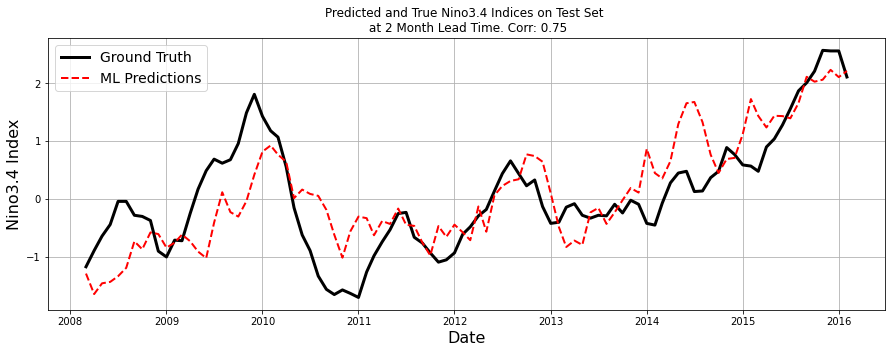

In [ ]:
#linear regression

X_train, y_train = assemble_predictors_predictands('1990-01-01','2005-12-31', 
                                                2,use_pca=True)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 2,
                                                  use_pca=True)
regr_1_month_lr = LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \n at 2 Month Lead Time. Corr: {:.2f}'.format(corr))

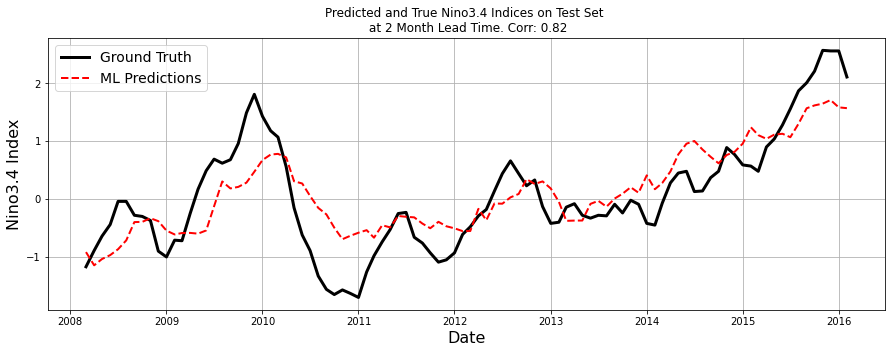

In [ ]:
#ridge regression
X_train, y_train = assemble_predictors_predictands('1990-01-01','2005-12-31', 
                                                2,use_pca=True)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 2,
                                                  use_pca=True)
regr_1_month_ridge = Ridge(alpha=80000)
regr_1_month_ridge.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_ridge.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \n at 2 Month Lead Time. Corr: {:.2f}'.format(corr))

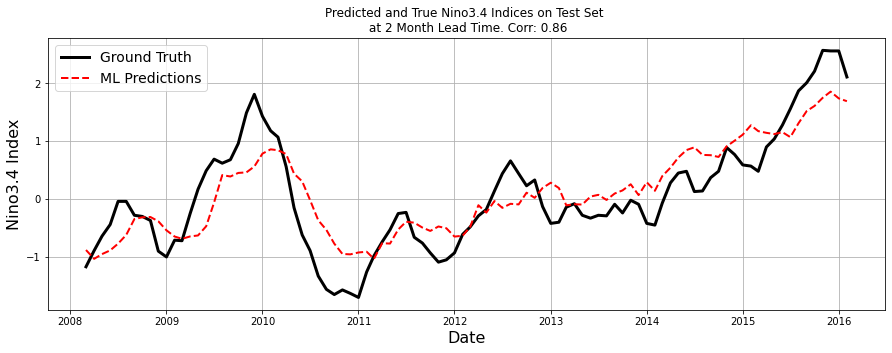

In [ ]:
#lasso regression

X_train, y_train = assemble_predictors_predictands('1990-01-01','2005-12-31', 
                                                2,use_pca=True)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 2,
                                                  use_pca=True)
regr_1_month_lasso = Lasso(alpha=3)
regr_1_month_lasso.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lasso.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \n at 2 Month Lead Time. Corr: {:.2f}'.format(corr))

## Check the Coefficient Fits

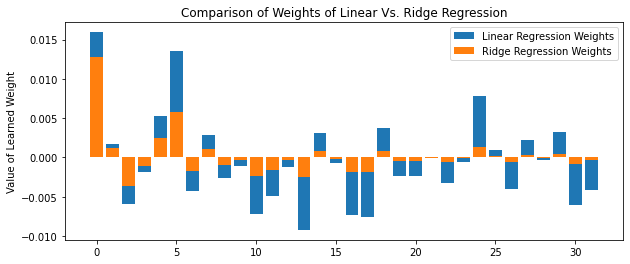

        ###################################################################


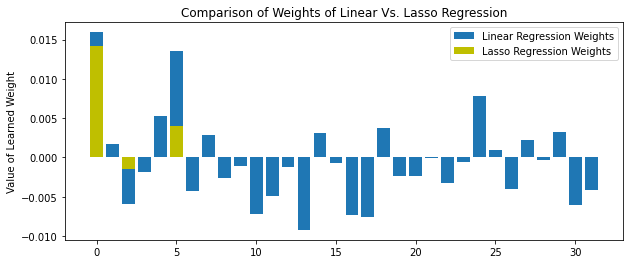

In [ ]:
"""In this cell, we will visualize how the weights of the linear 
regression model are bigger than those of the ridge regression model"""

regr_1_month_lr_weights = regr_1_month_lr.coef_
regr_1_month_lasso_weights = regr_1_month_lasso.coef_
regr_1_month_ridge_weights = regr_1_month_ridge.coef_

plt.figure(figsize=(10,4))
plt.bar(range(regr_1_month_lr_weights.shape[0]), regr_1_month_lr_weights,
        label='Linear Regression Weights')

plt.bar(range(regr_1_month_ridge_weights.shape[0]), regr_1_month_ridge_weights,
        label='Ridge Regression Weights')

plt.legend(loc='best')
plt.ylabel('Value of Learned Weight')
plt.title('Comparison of Weights of Linear Vs. Ridge Regression')
plt.show()

print('        ###################################################################')
plt.figure(figsize=(10,4))
plt.bar(range(regr_1_month_lr_weights.shape[0]), regr_1_month_lr_weights,
        label='Linear Regression Weights')
plt.bar(range(regr_1_month_lasso_weights.shape[0]), regr_1_month_lasso_weights,
        label='Lasso Regression Weights',color='y')

plt.legend(loc='best')
plt.ylabel('Value of Learned Weight')
plt.title('Comparison of Weights of Linear Vs. Lasso Regression')
plt.show()

# Exercise

Select the city and data you would like to use. There are multiple WFO datapoints, to look at then run: 

! ls AI_tutorial_data

** note, if you have restarted this notebook's Kernel, then you will have to reload the data at the top of this notebook. 


explore the scikit-learn tool box: 
https://scikit-learn.org/stable/modules/linear_model.html#

and try multiple models out! 





1. Choose a city / location 
2. Perform Preprocessing (grab the code from above)
3. Fit a model 
4. Evaluate the model. 


Alternatively, apply a categorical filter to the ENSO dataset and look at linear categorical models! (try logistic regression)






In [ ]:
! ls ./AI_tutorial_data

kast_processed_data.csv  kdbq_processed_data.csv  klch_processed_data.csv
kboi_processed_data.csv  kdfw_processed_data.csv  klit_processed_data.csv
kbro_processed_data.csv  kdlh_processed_data.csv  koma_processed_data.csv
kchs_processed_data.csv  keug_processed_data.csv  kroa_processed_data.csv
kcmh_processed_data.csv  kgeg_processed_data.csv
kcys_processed_data.csv  kjax_processed_data.csv


In [ ]:
! ls AI_tutorial_data 
# ## Location list ##
# #kbro - brownsville, TX
# #kcys - Cheyenne, WY
# #koma - Omaha, NE
# #kdbq - Dubuque, IA
#kcmh - Columbus, OH
#kchs - Charleston, SC
#klit - Little Rock, AK
#kboi - Boise, ID
#klch - Lake Charles, LA
#kgeg - Spokane, WA
#kdfw - Dallas-Ft Worth, TX
#kroa - Roanoke-Blacksburg, VA
#keug - Eugene, OR
#kast - Astoria, OR
#kdlh - Duluth, MN
#kjax - Jacksonville, FL

kast_processed_data.csv  kdbq_processed_data.csv  klch_processed_data.csv
kboi_processed_data.csv  kdfw_processed_data.csv  klit_processed_data.csv
kbro_processed_data.csv  kdlh_processed_data.csv  koma_processed_data.csv
kchs_processed_data.csv  keug_processed_data.csv  kroa_processed_data.csv
kcmh_processed_data.csv  kgeg_processed_data.csv
kcys_processed_data.csv  kjax_processed_data.csv


# Preprocessing -- first we must access and preprocess the data.

In [ ]:
total_dataset = pd.read_csv('AI_tutorial_data/kdfw_processed_data.csv',index_col=0).sort_values(by='date')
total_dataset = total_dataset.replace('********', np.nan).replace(np.inf,np.nan).dropna(how='any',axis=1)

#Observation data
total_label_data = total_dataset.filter(like='OBS')
print('These are the OBS',total_label_data)

#Variables used for training 
dropCols = list(total_label_data.columns) + ['date']
total_feature_data = total_dataset.copy(deep=True)
total_feature_data = total_feature_data.drop(dropCols,axis=1)
print('total feature data',total_feature_data)

# Remove MOS data based on previous work 
mosCols = [key for key in total_dataset.columns if 'MOS' in key]
total_dataset = total_dataset.drop(mosCols, axis = 1)

#Get total data
total_label_data = total_dataset.filter(like='OBS')
dropCols = list(total_label_data.columns)
total_feature_data = total_dataset.copy(deep=True).drop(dropCols,axis=1)

#Training data between 2011 and 2017
train_features, train_labels = split_data_year(total_feature_data,
    total_label_data,'2011-01-01','2017-12-31')

#Testing data between 2018 and 2019
# Keep a month between train/test data for greater likelihood 
# of dataset independence
test_features, test_labels = split_data_year(total_feature_data,
    total_label_data,'2018-02-01','2019-12-31')

#do thresholded min/max scaling. 
no_outlier_train_features = train_features.copy()
no_outlier_test_features = test_features.copy()

train_standard_dev = train_features.std()
train_mean = train_features.mean()

for column in train_features.columns:
  outlier_threshold_value = 3.0*train_standard_dev[column]
  
  #pandas.where() documentation:
  #Where condition is True, keep the original value. Where False, replace with corresponding value from other
  no_outlier_train_features[column].where(
      np.abs(train_features[column]-train_mean[column]) < outlier_threshold_value, 
      train_mean[column],
      inplace=True)
  
  no_outlier_test_features[column].where(
      np.abs(test_features[column]-train_mean[column]) < outlier_threshold_value, 
      train_mean[column],
      inplace=True)
  
#get scaled features 
no_outlier_min_max_model = MinMaxScaler().fit(no_outlier_train_features)
scaled_no_outlier_train_features = no_outlier_min_max_model.transform(no_outlier_train_features)
scaled_no_outlier_test_features = no_outlier_min_max_model.transform(no_outlier_test_features)

#get PCA features 
pca_model = PCA(n_components = 0.65, svd_solver = 'full').fit(scaled_no_outlier_train_features)
pca_train_features = pca_model.transform(scaled_no_outlier_train_features)
pca_test_features = pca_model.transform(scaled_no_outlier_test_features)

no_outlier_train_features.head(10)


These are the OBS       OBS_tmpf_max  OBS_tmpf_min  OBS_sknt_max  OBS_phour
0            44.06         30.02          14.0     0.0000
1            48.02         24.98           7.0     0.0000
2            57.92         30.92          18.0     0.0000
3            55.94         41.00           8.0     0.0000
4            57.92         35.96          12.0     0.0000
...            ...           ...           ...        ...
3135         93.90         79.00          16.0     0.0002
3136        100.00         77.00          12.0     0.0000
3137         97.00         75.00          11.0     0.0000
3138         93.90         78.10          10.0     0.0000
3142          0.00          0.00           0.0     0.0000

[3143 rows x 4 columns]
total feature data       GFS0_pmsl_max  GFS0_pmsl_min  ...  NAMMOS12_pos_min  NAMMOS12_pos_avg
0       1026.300000        1015.10  ...         41.666667         72.194444
1       1029.500000        1024.70  ...         50.000000         79.581845
2       1025.3

,GFS0_pmsl_max,GFS0_pmsl_min,GFS0_pmsl_avg,GFS0_pres_max,GFS0_pres_min,GFS0_pres_avg,GFS0_sktc_max,GFS0_sktc_min,GFS0_sktc_avg,GFS0_stc1_max,GFS0_stc1_min,GFS0_stc1_avg,GFS0_snfl_max,GFS0_snfl_min,GFS0_snfl_avg,GFS0_wtns_max,GFS0_wtns_min,GFS0_wtns_avg,GFS0_p01m_max,GFS0_p01m_min,GFS0_p01m_avg,GFS0_c01m_max,GFS0_c01m_min,GFS0_c01m_avg,GFS0_stc2_max,GFS0_stc2_min,GFS0_stc2_avg,GFS0_lcld_max,GFS0_lcld_min,GFS0_lcld_avg,GFS0_mcld_max,GFS0_mcld_min,GFS0_mcld_avg,GFS0_hcld_max,GFS0_hcld_min,GFS0_hcld_avg,GFS0_snra_max,GFS0_snra_min,GFS0_snra_avg,GFS0_uwnd_max,...,NAM4km18_td_max,NAM4km18_td_min,NAM4km18_td_avg,NAM4km18_wspd_max,NAM4km18_wspd_min,NAM4km18_wspd_avg,NAM4km18_wdir,NAM4km18_hiwc_max,NAM4km18_hiwc_min,NAM4km18_hiwc_avg,NAM4km18_qpf_max,NAM4km18_qpf_min,NAM4km18_qpf_avg,NAM4km18_qpf_accum_max,NAM4km18_qpf_accum_min,NAM4km18_qpf_accum_avg,NAM4km18_wagl_max,NAM4km18_wagl_min,NAM4km18_wagl_avg,NAM4km18_frz_rain_max,NAM4km18_frz_rain_min,NAM4km18_frz_rain_avg,NAM4km18_sleet_max,NAM4km18_sleet_min,NAM4km18_sleet_avg,NAM4km18_rh_max,NAM4km18_rh_min,NAM4km18_rh_avg,NAM4km18_buf_snow_sr_rate_max,NAM4km18_buf_snow_sr_rate_min,NAM4km18_buf_snow_sr_rate_avg,NAM4km18_buf_snow_maxt_rate_max,NAM4km18_buf_snow_maxt_rate_min,NAM4km18_buf_snow_maxt_rate_avg,NAM4km18_frz_rain_rate_max,NAM4km18_frz_rain_rate_min,NAM4km18_frz_rain_rate_avg,NAM4km18_sleet_rate_max,NAM4km18_sleet_rate_min,NAM4km18_sleet_rate_avg
1,1029.5,1024.7,1026.938889,1007.6,1003.1,1005.122222,8.9,-2.4,1.788889,278.1,276.4,277.038889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,99.0,0.0,39.666667,0.0,0.0,0.0,-0.8,...,21.6750,10.2375,15.653658,7.4000,2.1000,4.601662,121.242204,43.764278,23.799624,32.630096,0.00000,0.0,0.000000,0.000000,0.0,0.000000,15.152850,2.873035,7.845740,0.00000,0.0,0.000000,0.000000,0.0,0.000000,59.6625,28.3125,44.049950,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000
2,1025.3,1017.1,1021.183333,1003.6,995.6,999.562500,12.2,-1.2,4.475000,281.5,275.7,277.929167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,41.0,0.0,4.208333,95.0,0.0,44.250000,0.0,0.0,0.0,1.1,...,37.6500,20.8625,29.051241,14.1875,6.4125,9.565862,155.767756,56.840000,24.463062,38.794701,0.00000,0.0,0.000000,0.000000,0.0,0.000000,19.876904,11.433582,15.951065,0.00000,0.0,0.000000,0.000000,0.0,0.000000,72.1000,42.8125,58.930028,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000
3,1022.6,1016.0,1018.912500,1001.0,994.5,997.312500,14.4,1.7,6.820833,283.5,278.1,280.679167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,0.0,16.625000,50.0,0.0,11.916667,77.0,0.0,20.416667,0.0,0.0,0.0,2.7,...,45.3500,35.1375,40.961979,9.2125,1.0375,4.813542,195.867959,56.952500,36.569602,45.710986,0.00000,0.0,0.000000,0.002953,0.0,0.000677,16.696098,1.260547,7.734098,0.00000,0.0,0.000000,0.000000,0.0,0.000000,93.8250,62.9000,79.127604,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000
4,1019.5,1014.8,1016.875000,997.8,993.0,995.162500,13.6,0.6,6.166667,282.6,277.1,280.287500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.208333,0.0,0.0,0.000000,25.0,0.0,2.875000,0.0,0.0,0.0,4.3,...,39.7000,29.5750,34.280729,11.0625,2.4875,6.539063,277.445983,56.232500,33.779373,43.370708,0.00000,0.0,0.000000,0.002953,0.0,0.001230,15.330697,4.707223,10.093607,0.00000,0.0,0.000000,0.000000,0.0,0.000000,88.8750,42.4500,66.315625,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000
5,1022.2,1014.7,1018.979167,1000.4,993.2,997.279167,14.9,1.8,6.629167,283.4,278.0,280.454167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,98.0,0.0,62.208333,0.0,0.0,0.0,4.2,...,33.5500,26.2500,30.164583,10.6500,4.0750,7.319271,303.825360,59.787500,28.780920,43.010440,0.00000,0.0,0.000000,0.002953,0.0,0.000533,17.208836,6.672951,12.345721,0.00000,0.0,

In [ ]:
pca_train_features.shape

(2558, 5)

# Briefly Explore your data

- simple plots are best! (ie. distributions of independent vs dependent variables)
- histograms / distributions 
-remove the seasonal cycle??? see if your model is any good (it's probably not). 
- Use your imagination here + your knowledge of the science 

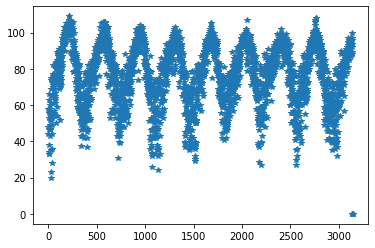

In [ ]:
# Target variable plot: 
plt.plot(total_label_data['OBS_tmpf_max'],'*')
plt.show()

In [ ]:
# plt.hist(pca_train_features[:,5],50)
# plt.show()

# Fit a model here: 

- try a suite of models (see the linked SKLEARN package!)
- try varying the length of training data
- try ridge & lasso regression 
- explore other linear models! 

In [ ]:
tfit.shape

(552, 5)

Coeffiecients: [-12.73897102  -7.13450229   0.39412342   0.          -0.        ]
Intercept: 77.74820172009382


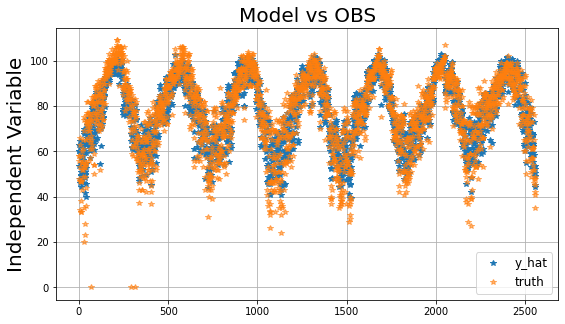

In [ ]:
from sklearn import linear_model

#scale the input parameters. to help with interpretation. 
tfit = (pca_train_features-np.mean(pca_train_features,axis=0))/np.std(pca_train_features,axis=0)

# linreg_model = LinearRegression() #grab the linear regression module from the SKLEARN package------ 
linreg_model = linear_model.Lasso(alpha=1)

# High Temperature Model
high_temp_linreg = linreg_model.fit(tfit,train_labels['OBS_tmpf_max'].values)
print('Coeffiecients:',high_temp_linreg.coef_)
print('Intercept:',high_temp_linreg.intercept_)

#how does our fit look? THIS IS OUR MODEL! 
plt.figure(figsize=(9,5))
plt.plot(np.matmul(tfit,high_temp_linreg.coef_)+high_temp_linreg.intercept_,'*',label='y_hat') #this is how you get your prediction back! 
plt.plot(train_labels['OBS_tmpf_max'].values,'*',label='truth',alpha=0.6)
plt.grid(True)
plt.title('Model vs OBS',fontsize=20)
plt.ylabel('residual',fontsize=20)
plt.ylabel('Independent Variable',fontsize=20)
plt.legend(fontsize=12)
plt.show()

# Evaluate your model

-make a residual plot

-determine bias, MSE, MAE, etc. 

-make a binned reliability curve

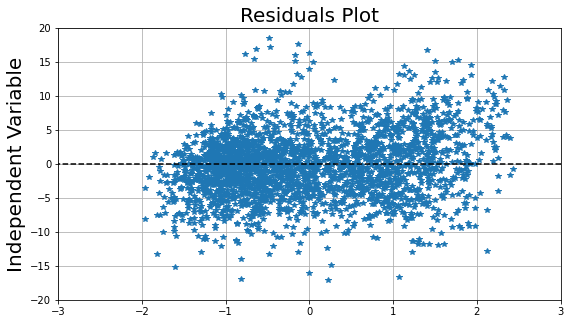

In [ ]:
yhat_sub = np.matmul(tfit,high_temp_linreg.coef_) + high_temp_linreg.intercept_
truth = train_labels['OBS_tmpf_max'].values
resids = yhat_sub-truth
plt.figure(figsize=(9,5))
plt.plot(tfit[:,1],resids,'*') #which feature? change the value in tfit
plt.ylim([-20,20])
plt.xlim([-3,3])

plt.grid(True)
plt.plot([-10,20],[0,0],'k',linestyle='--') #add a zero line
plt.title('Residuals Plot',fontsize=20)
plt.ylabel('residual',fontsize=20)
plt.ylabel('Independent Variable',fontsize=20)
plt.show()

Mean square error: 40.71076083691827

Predicted values 
[56.5335636  61.17285862 59.76499581 53.80141932 51.41115329 49.55876812
 62.93599796 65.87071821 56.76448755 48.76003686]

Actual values 
[54.  60.1 66.  46.  44.1 50.  61.  72.  60.1 43. ]


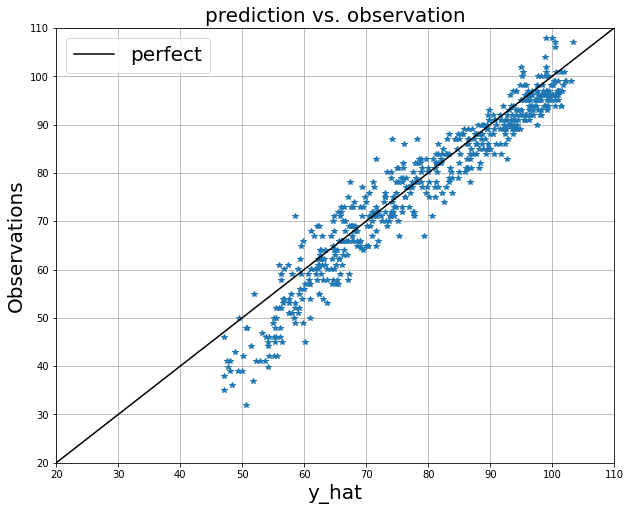

In [ ]:
tfit = (pca_test_features-np.mean(pca_train_features,axis=0))/np.std(pca_train_features,axis=0) ## This is happening on the testing data!!! 

high_temp_y_pred = high_temp_linreg.predict(tfit)
high_temp_mse = mean_squared_error(high_temp_y_pred,test_labels['OBS_tmpf_max'].values)

print(f'Mean square error: {high_temp_mse}')
print(f'\nPredicted values \n{high_temp_y_pred[:10]}')
print(f'\nActual values \n{test_labels["OBS_tmpf_max"].values[:10] }')

plt.figure(figsize=(10,8))
plt.plot(high_temp_y_pred,test_labels['OBS_tmpf_max'].values,'*')
plt.xlim([20,110])
plt.ylim([20,110])
plt.grid(True)
plt.title('prediction vs. observation',fontsize=20)
plt.ylabel('Observations',fontsize=20)
plt.xlabel('y_hat',fontsize=20)
plt.plot([20,110],[20,110],color='k',label='perfect')
plt.legend(fontsize=20)
plt.show()

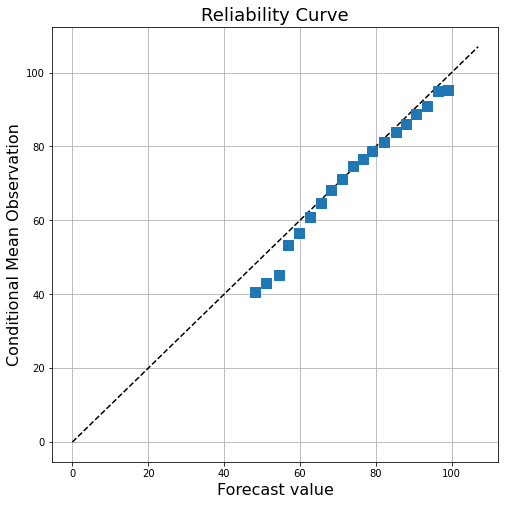

In [ ]:
regression_reliability_curve(high_temp_y_pred, test_labels['OBS_tmpf_max'].values, nbins=20)

# Categorical ENSO predictions

apply a categorical filter to the ENSO dataset and look at linear categorical models! (try logistic regression)

In [ ]:
X_train, y_train = assemble_predictors_predictands('1950-01-01','2005-12-31', 
                                                5,use_pca=True)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 5,
                                                  use_pca=True)


#change y_train/y_test to categorical variable based on a threshold
threshy=0.5 #K/C
y_train_cat = np.zeros_like(y_train)
y_train_cat[y_train>threshy] = 1 #Nino conditions 
y_train_cat[y_train<-threshy] = 2 #Nina conditions 

y_test_cat = np.zeros_like(y_test)
y_test_cat[y_test>threshy] = 1 #Nino conditions 
y_test_cat[y_test<-threshy] = 2 #Nina conditions 


#Fit the Model

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train_cat)

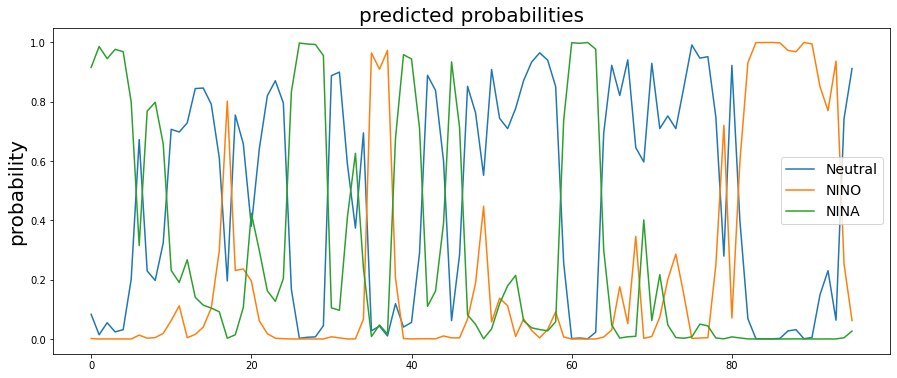

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(clf.predict_proba(X_test)[:,0],label='Neutral')
plt.plot(clf.predict_proba(X_test)[:,1],label='NINO')
plt.plot(clf.predict_proba(X_test)[:,2],label='NINA')

plt.ylabel('probability',fontsize=20)
plt.title('predicted probabilities',fontsize=20)
plt.legend(fontsize=14)
plt.show()

#Evaluate your model

-roc diagram 

-hits vs misses 

-contigency table


note this link for a ton of verification techniques: 
https://scikit-learn.org/stable/modules/model_evaluation.html



In [ ]:
print(clf.score(X_test,y_test_cat),'accuracy') ##accuracy
print(sklearn.metrics.balanced_accuracy_score(y_test_cat,clf.predict(X_test)),'balanced accuracy')

0.5833333333333334 accuracy
0.5698872785829306 balanced accuracy


In [ ]:
sklearn.metrics.roc_auc_score(y_test_cat, clf.predict_proba(X_test), multi_class='ovr')

0.7600120190577279

In [ ]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(solver="liblinear").fit(X, y)
sklearn.metrics.roc_auc_score(y, clf.predict_proba(X), multi_class='ovr')


0.9913333333333334

In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_test_cat_bin = label_binarize(y_test_cat, classes=[0, 1, 2])
y_train_cat_bin = label_binarize(y_train_cat, classes=[0, 1, 2])

# Learn to predict each class against the other
classifier = LogisticRegression(random_state=0)
y_score = classifier.fit(X_train, y_train_cat).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_cat_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

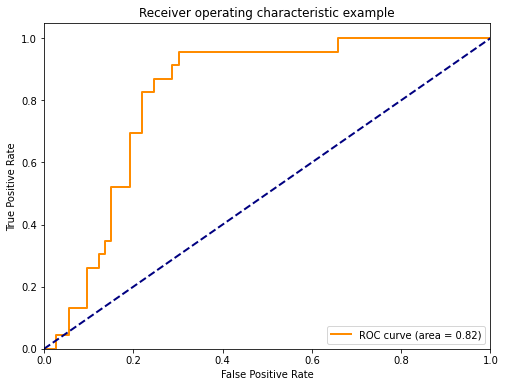

In [ ]:
plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr[2],tpr[2],color="darkorange",lw=lw,label="ROC curve (area = %0.2f)" % roc_auc[2])
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

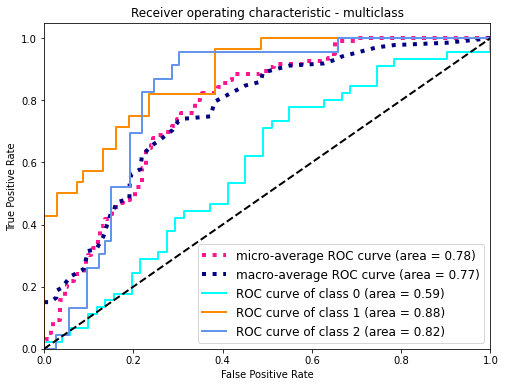

In [ ]:
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr["micro"],tpr["micro"],
         label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",linestyle=":",linewidth=4,)

plt.plot(
    fpr["macro"],tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",linestyle=":",linewidth=4,)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i],tpr[i],color=color,lw=lw,label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic - multiclass")
plt.legend(loc="lower right",fontsize=12)
plt.show()

In [ ]:
#scale the input parameters. to help with interpretation. 
tfit = (pca_train_features-np.mean(pca_train_features,axis=0))/np.std(pca_train_features,axis=0)

linreg_model = LinearRegression() #grab the linear regression module from the SKLEARN package
# High Temperature Model
high_temp_linreg = linreg_model.fit(tfit,train_labels['OBS_tmpf_max'].values)
print('Coeffiecients:',high_temp_linreg.coef_)
print('Intercept:',high_temp_linreg.intercept_)

Coeffiecients: [-19.42203392  -6.37136061   0.2236975    0.8212785    1.88199722
   0.44551056  -0.50694192  -0.1744386 ]
Intercept: 64.2261328125


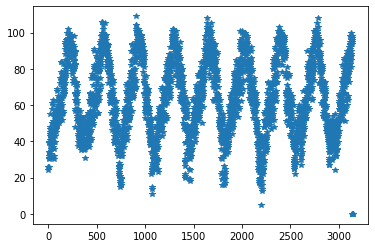

In [ ]:
plt.plot(total_label_data['OBS_tmpf_max'],'*')
plt.show()

In [ ]:
total_label_data

,OBS_tmpf_max,OBS_tmpf_min,OBS_sknt_max,OBS_phour
0,24.08,8.96,10.0,0.0
1,26.06,17.06,10.0,0.0
2,26.06,10.94,7.0,0.0
3,26.06,10.94,6.0,0.0
4,30.92,15.98,7.0,0.0
...,...,...,...,...
3134,96.10,69.10,10.0,0.0
3135,97.00,64.90,8.0,0.0
3136,98.10,63.00,7.0,0.0
3137,98.10,63.00,7.0,0.0


In [ ]:
data_file = 'AI_tutorial_data/keug_processed_data.csv'
total_dataset = pd.read_csv(data_file,index_col=0).sort_values(by='date')

###########################
# Do not need to change the following lines
###########################


# Remove MOS data, unknown strings, and NaN values
mosCols = [key for key in total_dataset.columns if 'MOS' in key]
total_dataset = total_dataset.replace('********', np.nan).replace(np.inf,np.nan).dropna(how='any',axis=1).drop(mosCols, axis = 1)

#Get label data
total_label_data = total_dataset.filter(like='OBS')

#Get feature data
dropCols = list(total_label_data.columns)
total_feature_data = total_dataset.copy(deep=True).drop(dropCols,axis=1)

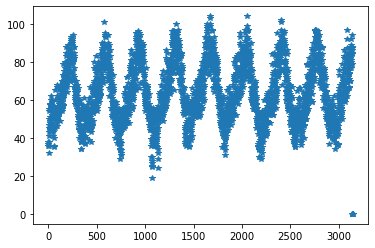

In [ ]:
plt.plot(total_label_data['OBS_tmpf_max'],'*')

---

Choose the train, validation, test split based on time periods

See **Data Pre-processing > Partioning Data** Section

---

In [ ]:
# Function to split data based on given dates
def split_data_year(input_data,labels,start_date_str,end_date_str):
  data = input_data.copy()
  date_list = pd.to_datetime(data['date'])
  date_mask = (date_list > start_date_str) & (date_list <= end_date_str)
  out_data = data.loc[date_mask,:].drop(['date'],axis=1)
  out_labels = labels.loc[date_mask,:]
  return out_data,out_labels

In [ ]:
###########################
# Will need to change the rest of the lines in the exercise
###########################


#Training data 
train_features, train_labels = split_data_year(total_feature_data,total_label_data,'2011-01-01','2017-12-31')

# #Validation data
# valid_features, valid_labels = split_data_year(total_feature_data,total_label_data,'','')

#Testing data
test_features, test_labels = split_data_year(total_feature_data,total_label_data,
                                             '2018-02-01','2019-12-31')

In [ ]:
train_features.shape

(2561, 2520)

In [ ]:
train_labels.shape

(2561, 4)

---
Apply transformations and Principal Component Analysis (optional) to data.

*I highly suggest using PCA so that the ML models train in a timely manner*


See  **Data Pre-processing > Normalization and Scaling** and **Data Pre-processing > Dimensionlanlity Reduction > Principal Component Analysis** Sections. 


Other scaling tranformations [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).

---

In [ ]:
# import PCA and/or metrics 


# First transform training data
no_outlier_train_features = train_features.copy()
no_outlier_test_features = test_features.copy()

train_standard_dev = train_features.std()
train_mean = train_features.mean()

for column in train_features.columns:
  outlier_threshold_value = 3.0*train_standard_dev[column]
  
  #pandas.where() documentation:
  #Where cond is True, keep the original value. Where False, replace with corresponding value from other
  no_outlier_train_features[column].where(
      np.abs(train_features[column]-train_mean[column]) < outlier_threshold_value, 
      train_mean[column],
      inplace=True)
  
  no_outlier_test_features[column].where(
      np.abs(test_features[column]-train_mean[column]) < outlier_threshold_value, 
      train_mean[column],
      inplace=True)
  
from sklearn.preprocessing import MinMaxScaler

no_outlier_min_max_model = MinMaxScaler().fit(no_outlier_train_features)
scaled_no_outlier_train_features = no_outlier_min_max_model.transform(no_outlier_train_features)

scaled_no_outlier_test_features = no_outlier_min_max_model.transform(no_outlier_test_features)

In [ ]:
pca = PCA(n_components=0.65,svd_solver='full')
pca.fit(scaled_no_outlier_train_features)
pca_train_features = pca.transform(scaled_no_outlier_train_features)
pca_test_features = pca.transform(scaled_no_outlier_test_features)

In [ ]:
scaled_no_outlier_train_features.shape

(2561, 2520)

In [ ]:
pca_train_features.shape

(2561, 7)

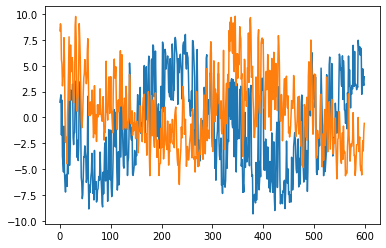

In [ ]:
plt.plot(pca_train_features[:600,0])
plt.plot(pca_train_features[:600,1])

In [ ]:
np.corrcoef(pca_train_features[:600,1],pca_train_features[:600,0])

array([[1.        , 0.00853911],
       [0.00853911, 1.        ]])

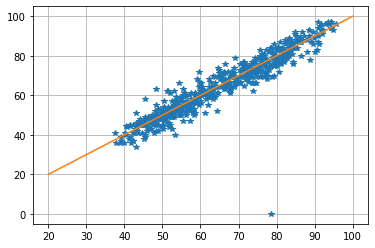

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


model_jacob = LinearRegression()
ridge_model = Ridge(alpha=30)
# High Temperature Model
high_temp_ridgereg = ridge_model.fit(pca_train_features,train_labels['OBS_tmpf_max'].values)
high_temp_y_pred = high_temp_ridgereg.predict(pca_test_features)



plt.plot(high_temp_y_pred,test_labels['OBS_tmpf_max'].values,'*')
plt.grid(True)
plt.plot([20,100],[20,100])
# model_jacob.fit(pca_train_features,train_labels['OBS_tmpf_max'].values)
plt.show()


In [ ]:
high_temp_ridgereg.coef_

array([ 2.43386262, -2.59849686, -0.13996246,  0.14272429,  0.68052672,
       -0.54035462,  1.57854073])

In [ ]:
np.corrcoef(high_temp_y_pred,test_labels['OBS_tmpf_max'].values)[0,1]

0.9375908327015205

*italicized text*

In [ ]:
train_labels['OBS_tmpf_max'].values

array([37.04, 35.96, 37.94, ..., 55.9 , 50.  , 39.  ])

----
Tune model hyperparameters using validation data, could be cross-validation such as:
```
RandomizedSearchCV()
```

See **Model Training > Hyperparameter Tuning** Section


CV function description [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

---

In [ ]:
#import CV function

random_search = RandomizedSearchCV()
random_search.fit(pca_valid_features,valid_labels) #validation data
tuned_model_parameters = random_search.best_params_

---
Fit/Train ML models using the tuned model parameters and training data

See **Model Training > Fitting Linear Regression Model** Section


Information about different models [here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

---

In [ ]:
#import model function
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=150,max_depth=6)
rf_model.fit(pca_train_features,train_labels['OBS_sknt_max'].values) #training data


---
Evaluate model, change up dataset or training features if wanted

See **Model Evaluation** Section

Information about evalution metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html)

---

In [ ]:
# import metrics 

pred_labels = rf_model.predict(pca_test_features) #testing data

# Compare pred_labels to test_labels with metrics and/or reliability diagram




NameError: ignored

In [ ]:
# Reliability curve of high temperature linear regression model
regression_reliability_curve(pred_labels, test_labels['OBS_sknt_max'].values, nbins=20)

In [ ]:
from sklearn.metrics import mean_squared_error
wind_mse = mean_squared_error(pred_labels,test_labels['OBS_sknt_max'].values)

print(f'Mean square error: {wind_mse}')
print(f'\nPredicted values \n{pred_labels[:10]}')

print(f'\nActual values \n{test_labels["OBS_sknt_max"].values[:10] }')